In [41]:
import os

import matplotlib
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
from glob import glob
import seaborn as sns

import anndata 
from scipy.sparse import csr_matrix

from matplotlib import pyplot as plt, cm as mpl_cm
import warnings

import celltypist
from celltypist import models

import bbknn

### General settings

In [42]:
warnings.filterwarnings("ignore")

anndata.logging.anndata_logger.addFilter(
    lambda r: not r.getMessage().startswith("storing")
    and r.getMessage().endswith("as categorical.")
)

sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)

#set figure parameters
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, frameon=True, vector_friendly=True, fontsize=14,
                         figsize=None, color_map=None, format='png', facecolor=None, transparent=False, ipython_format='png2x')


#To see nice images or change to jupyter renderers extension
%matplotlib inline 

### Setting the data directory

After processing the fastq files with the BD Rhapsody WTA pipeline, we did the following:

    1. Split the "combined_DBEC_MolsPerCell.csv" file into two files "BD_WTA_DBEC_MolsPerCell.csv" containing only transcripts and "BD_AbSeq_DBEC_MolsPerCell.csv" containing the receptor counts of CD4 and CD8A.

    2. Processing the "BD_VDJ_Dominant_Contigs.csv" file to generated cellranger-like output files "filtered_contig_annotations.csv" and "filtered_contig.fasta" files using 'BdRhapTo10Xconverter' Java class, followed by a typical ChangeO workflow (IgBlast annotation and changeo functions) to generate an AIRR table of filtered clonotypes (see 'processed_files/BD_filtered_contig_igblast_db-pass_parse-select.tsv')


In [43]:

wk_dir = os.getcwd() 
processed_files_dir="processed_files/"
data_dir = wk_dir+"/BD_WTA_pipeline_out/" 
imageFormat ='pdf'

#make some directories
out_BD=wk_dir+"/analysis_out_BD/"
if not os.path.exists(out_BD):
    os.mkdir(out_BD)

out_dir = out_BD+"files/"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

fig_dir= out_BD+"figures/"
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

gexdir=out_BD+'figures/GEX/'
if not os.path.exists(gexdir):
    os.mkdir(gexdir)

irdir=out_BD+'figures/IR/'
if not os.path.exists(irdir):
    os.mkdir(irdir)

sc.settings.figdir=gexdir

print("DATA DIRECTORY is "+data_dir)



DATA DIRECTORY is /home/localadmin/github_PUBLICATIONS/manuscript-tcell-fallet/BD_WTA_pipeline_out/


### First we normalize the protein count (Ab)

In [44]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [45]:
from pickle import TRUE


prot_file = data_dir+'BD_AbSeq_DBEC_MolsPerCell.csv'
protein= sc.read_csv(prot_file,first_column_names=TRUE)

print(protein)

clr_normalize_each_cell(protein)
sc.pp.log1p(protein)
prot_file_norm = out_dir+'BD_Ab_DBEC_MolsPerCell_normalized.csv'
print(protein)

# we write in a file the normalized values
t=protein.X
pd.DataFrame(data=t, index=protein.obs_names, columns=protein.var_names).to_csv(prot_file_norm)


AnnData object with n_obs × n_vars = 2072 × 2
AnnData object with n_obs × n_vars = 2072 × 2
    uns: 'log1p'


#### Then we do the GEX data by creating the AnnotationData object

PROCESSING...
(2072, 15842)
(2072, 15842)
Cells with tcr: (1213, 0)
Cells with GEX: (2072, 15842)


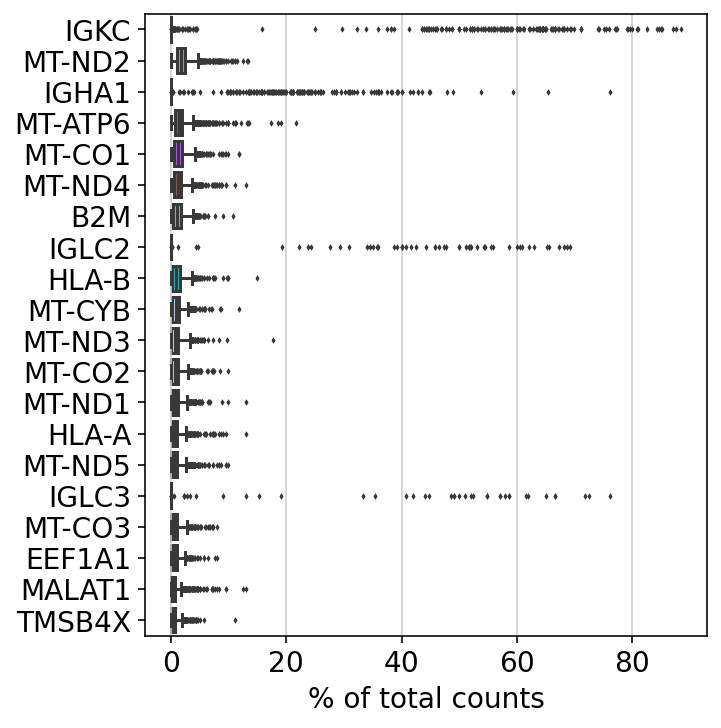

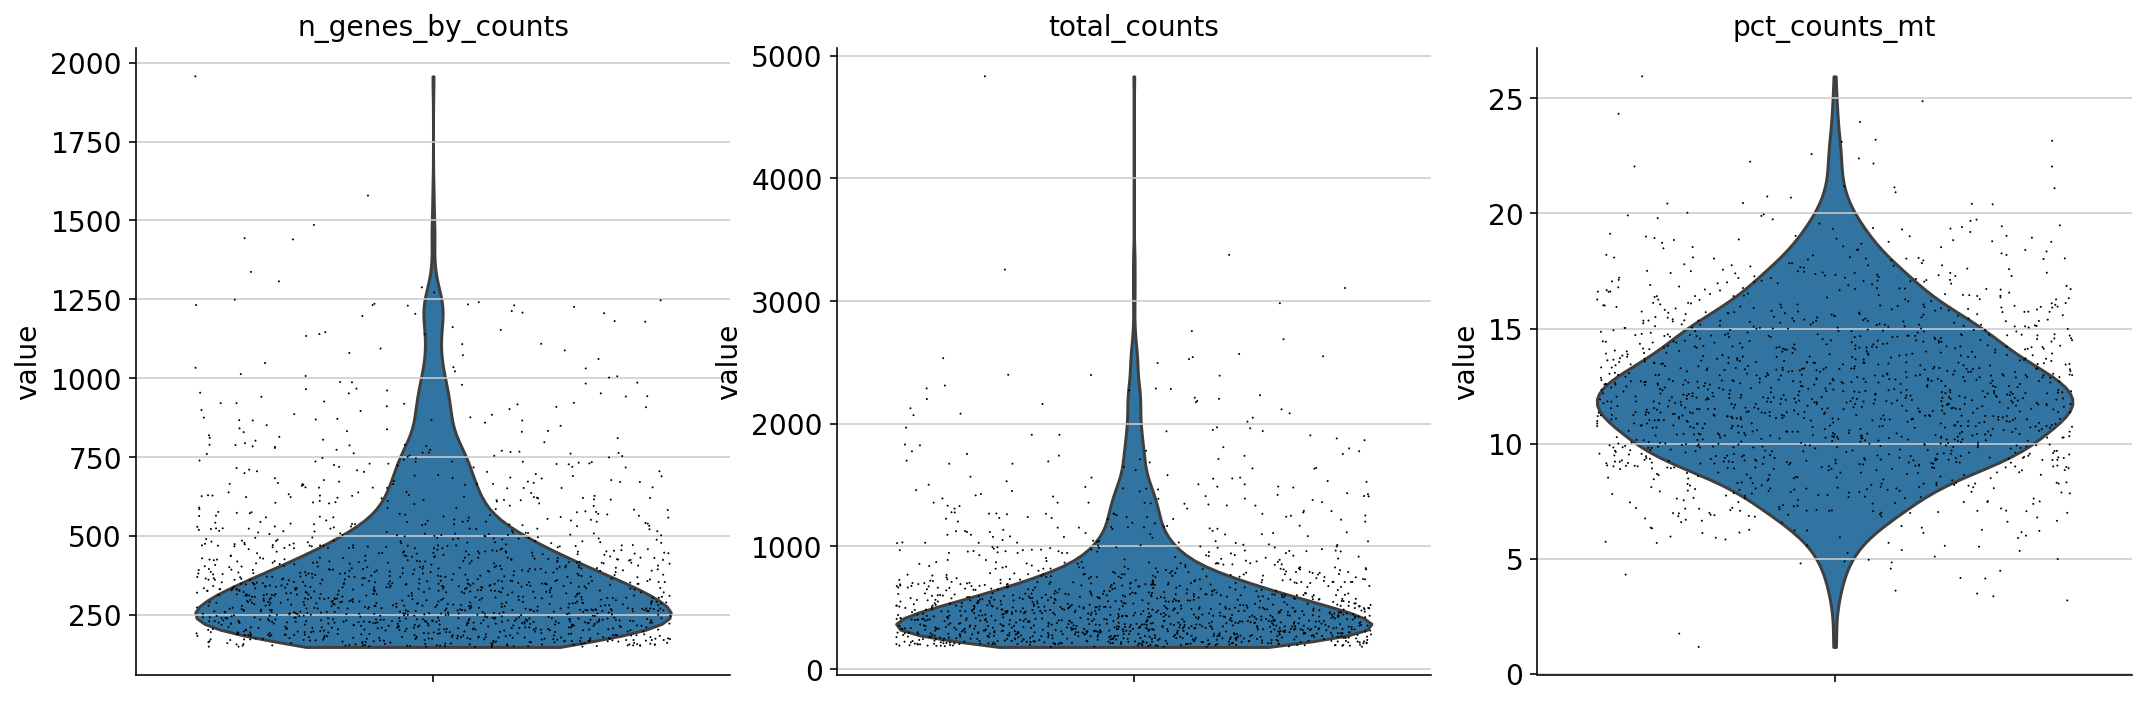

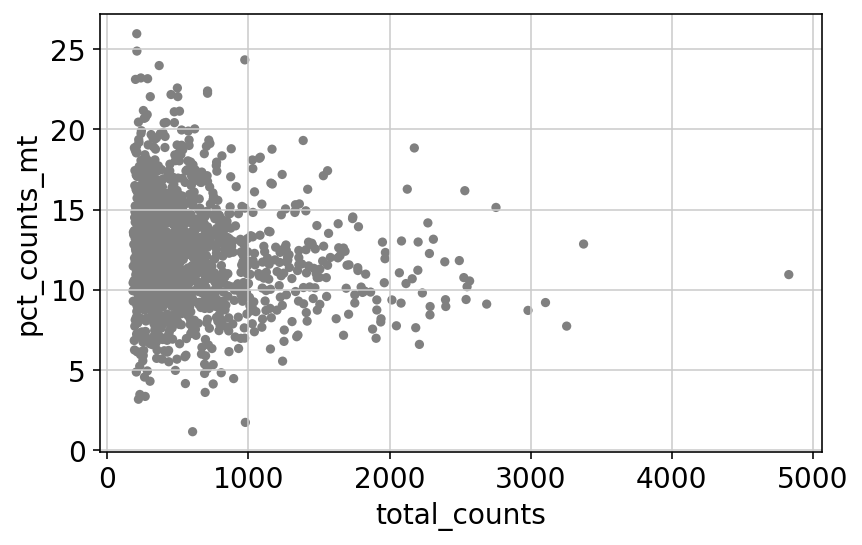

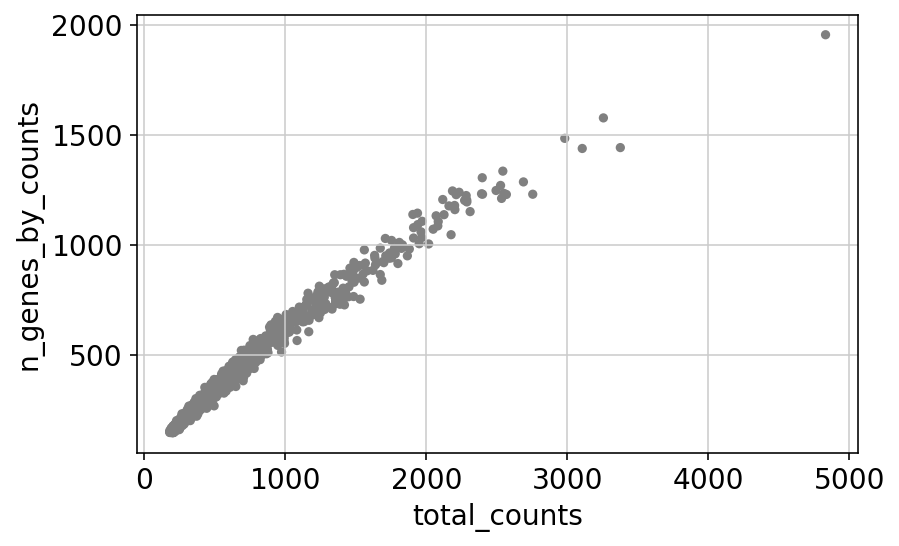

After filtering, cells with GEX: (1369, 10403)
AnnData object with n_obs × n_vars = 1369 × 10403
    obs: 'cell_type_exp', 'sample', 'CD4.prot', 'CD8A.prot', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_producti

In [46]:

print("PROCESSING...")
# Load the associated transcriptomics data
gex_file = data_dir+"BD_WTA_DBEC_MolsPerCell.csv"
adata = sc.read_csv(gex_file,first_column_names=TRUE)
print(adata.shape)

#We add the info about the cell type and the sample name
cellType_anno=pd.read_csv(data_dir+"BD_cell_type_experimental.csv")
adata.obs["cell_type_exp"] = list(cellType_anno['Cell_Type_Experimental'])
adata.obs["cell_type_exp"] = adata.obs["cell_type_exp"].astype('category')

sample_tag_anno=pd.read_csv(data_dir+"BD_Sample_Tag_Calls.csv")
adata.obs["sample"] = list(sample_tag_anno['Sample_Name'])
adata.obs["sample"] = adata.obs["sample"].astype('category')

#we add the normalized protein count
adata.obs["CD4.prot"] =protein[:,["CD4.prot"]].X
adata.obs["CD8A.prot"] =protein[:,["CD8A.prot"]].X
print(adata.shape)

# Load the TCR data
tcr_file = processed_files_dir+"/BD_filtered_contig_igblast_db-pass_parse-select.tsv"
adata_tcr = ir.io.read_airr(tcr_file)

print("Cells with tcr:", adata_tcr.shape)
print("Cells with GEX:", adata.shape)

# Preprocessing
adata.var_names_make_unique()
sc.pl.highest_expr_genes(
    adata, n_top=20, save="_highestGenes."+imageFormat)

# basic filtering
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=3)
# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, save="_QCmetrics."+imageFormat)
# Remove cells that have too many mitochondrial genes expressed or too many total counts:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',
              save="_UMI_mt."+imageFormat)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',
              save="_UMI_feat."+imageFormat)
# Actually do the filtering by slicing the AnnData object
adata = adata[adata.obs.n_genes_by_counts > 100, :]
adata = adata[adata.obs.total_counts < 3000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]


print("After filtering, cells with GEX:", adata.shape)
ir.pp.merge_with_ir(adata, adata_tcr)


print(adata)


RNAseq: total cell number = (1369, 10403)


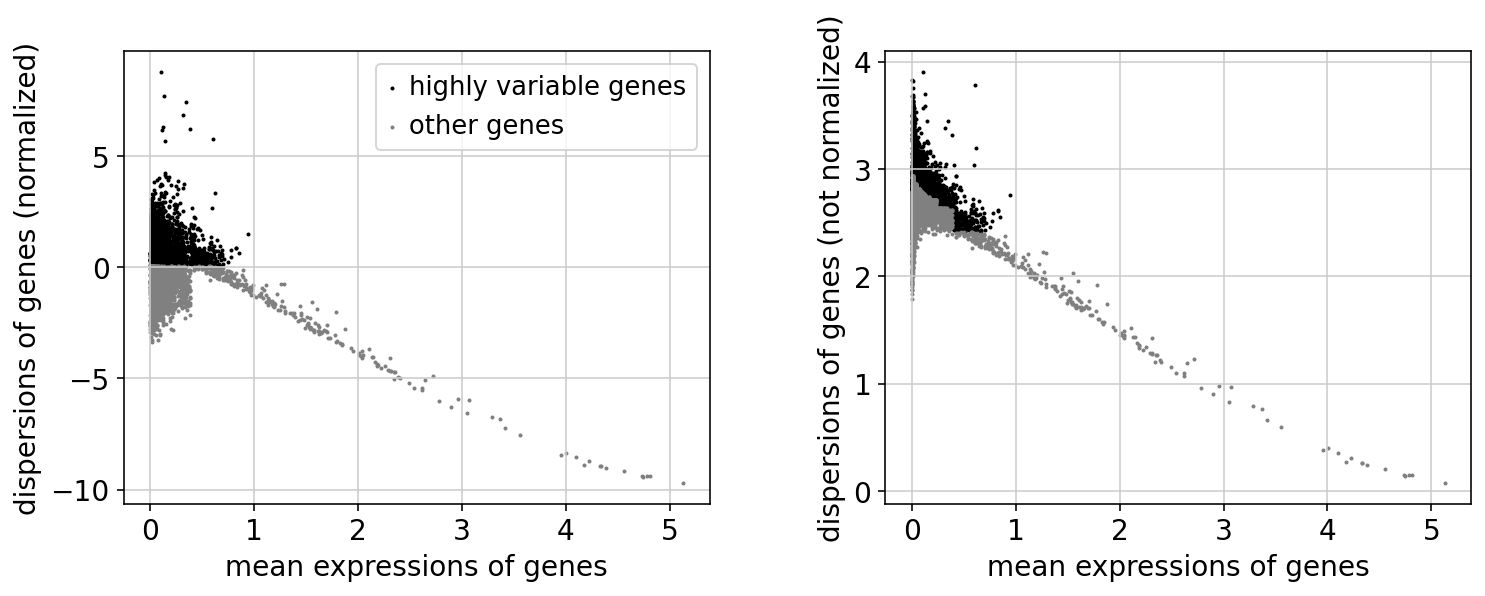

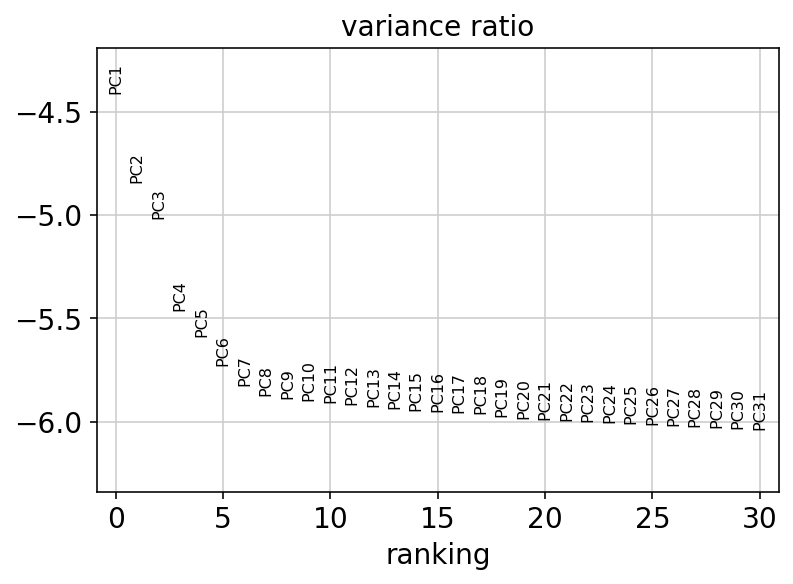

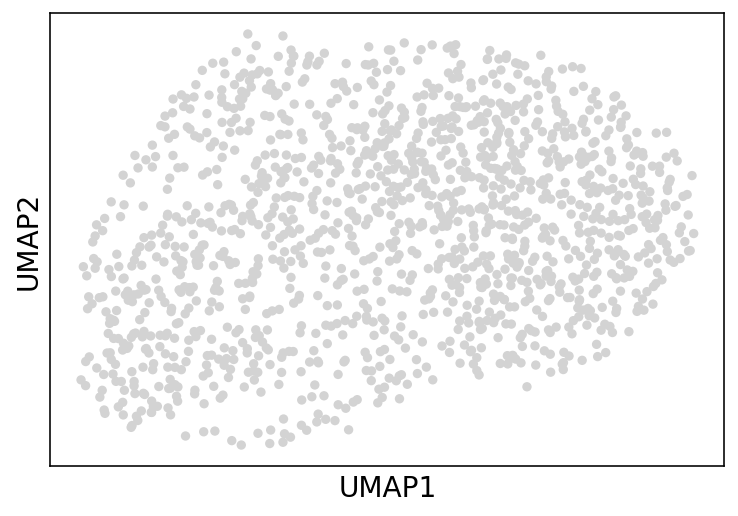

In [47]:

##################################
## transciptomics data ANALYSIS ##
##################################

print("RNAseq: total cell number =", adata.shape)

# normalize count
sc.pp.normalize_total(adata, target_sum=1e4)
# Log the data
sc.pp.log1p(adata)

#Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=5000)
sc.pl.highly_variable_genes(adata, save='.'+imageFormat)

#Reduce the dimensionality of the data by running principal component analysis (PCA),
# which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack')

#how many PCs to consider
sc.pl.pca_variance_ratio(adata, log=True, save='.'+imageFormat)
#Correcting bacth effect with BBKNN
sc.external.pp.bbknn(adata, batch_key='sample') 
#Embedding the neighborhood graph
sc.tl.umap(adata)
sc.pl.umap(adata)
#Clustering the neighborhood graph
sc.tl.leiden(adata, resolution=0.5)

### Make some UMAP plots

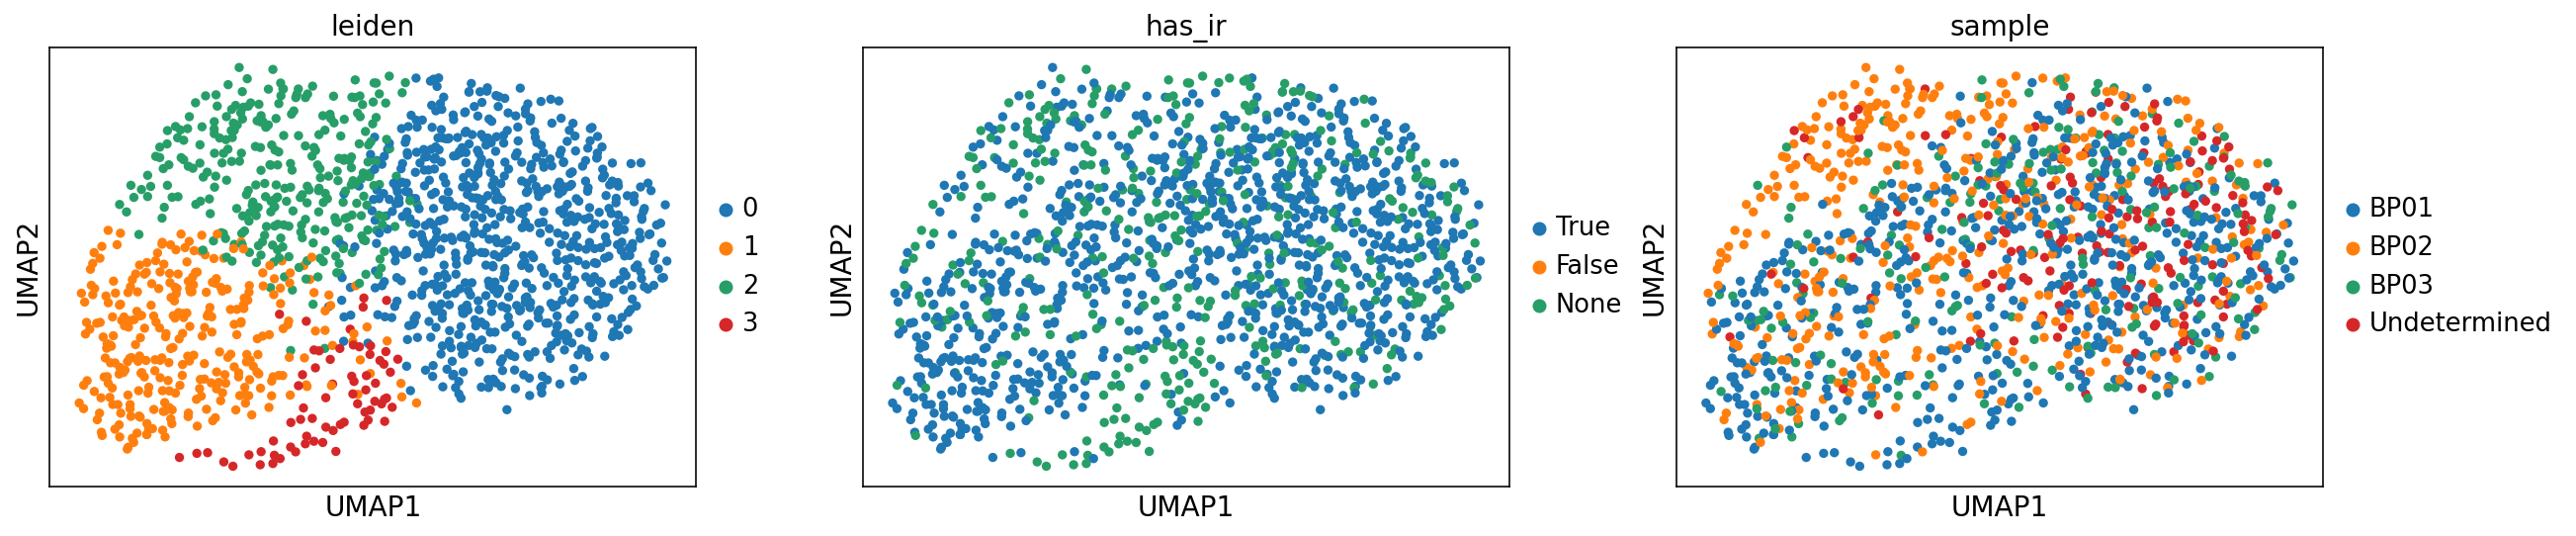

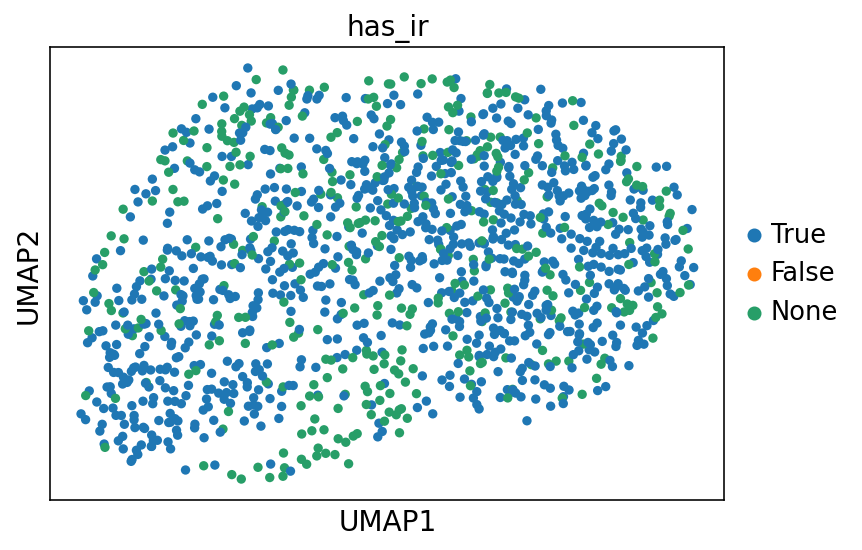

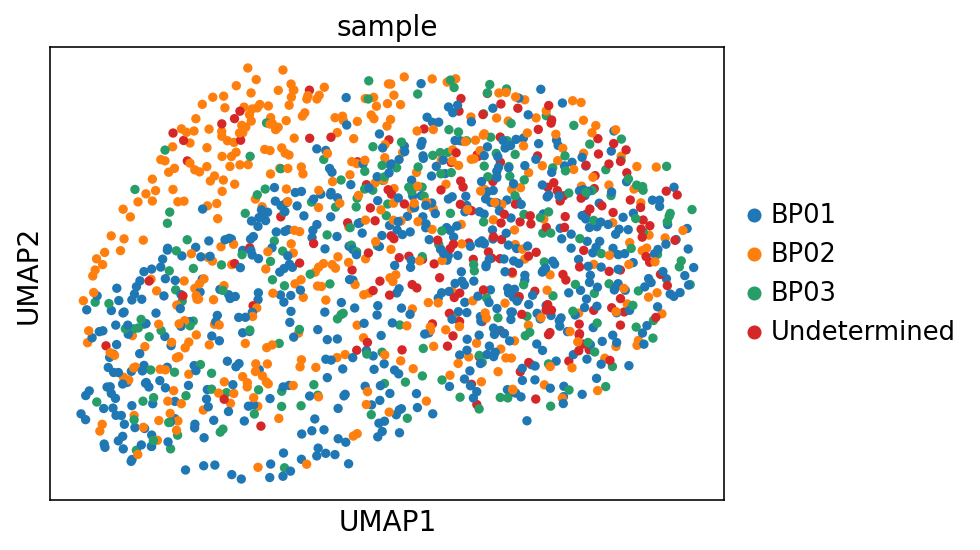

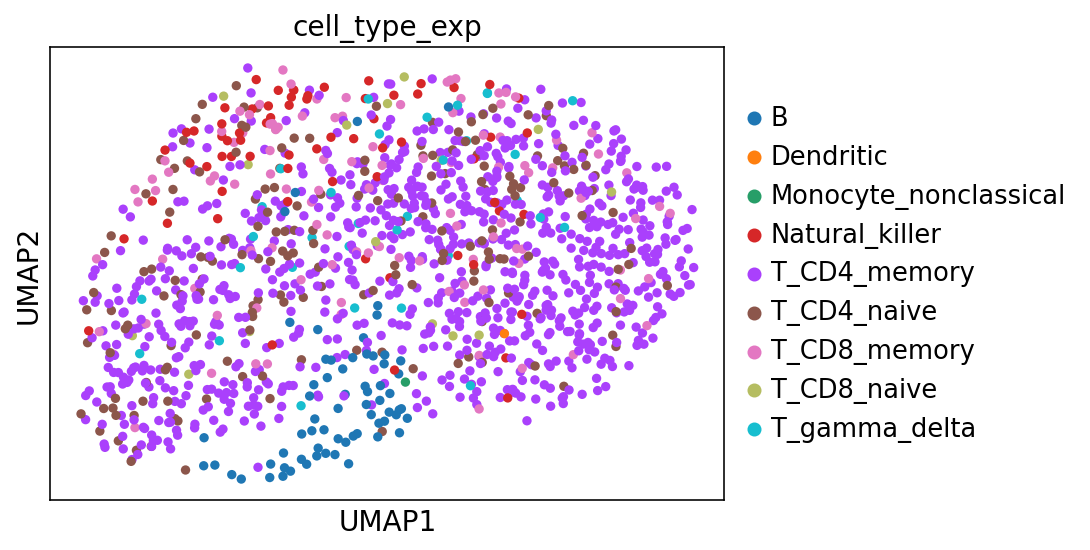

In [48]:
#Makes some plots

sc.pl.umap(adata, color=['leiden', 'has_ir', 'sample'], save='_withTCR_batch.'+imageFormat)

sc.pl.umap(adata, color=["has_ir"], save='_TCR.'+imageFormat)

sc.pl.umap(adata, color=["sample"], save='_sample.'+imageFormat)
sc.pl.umap(adata, color=["cell_type_exp"], save='_cellTypeExp.'+imageFormat)

#### Make UMAP with CD4 and CD8A proteins

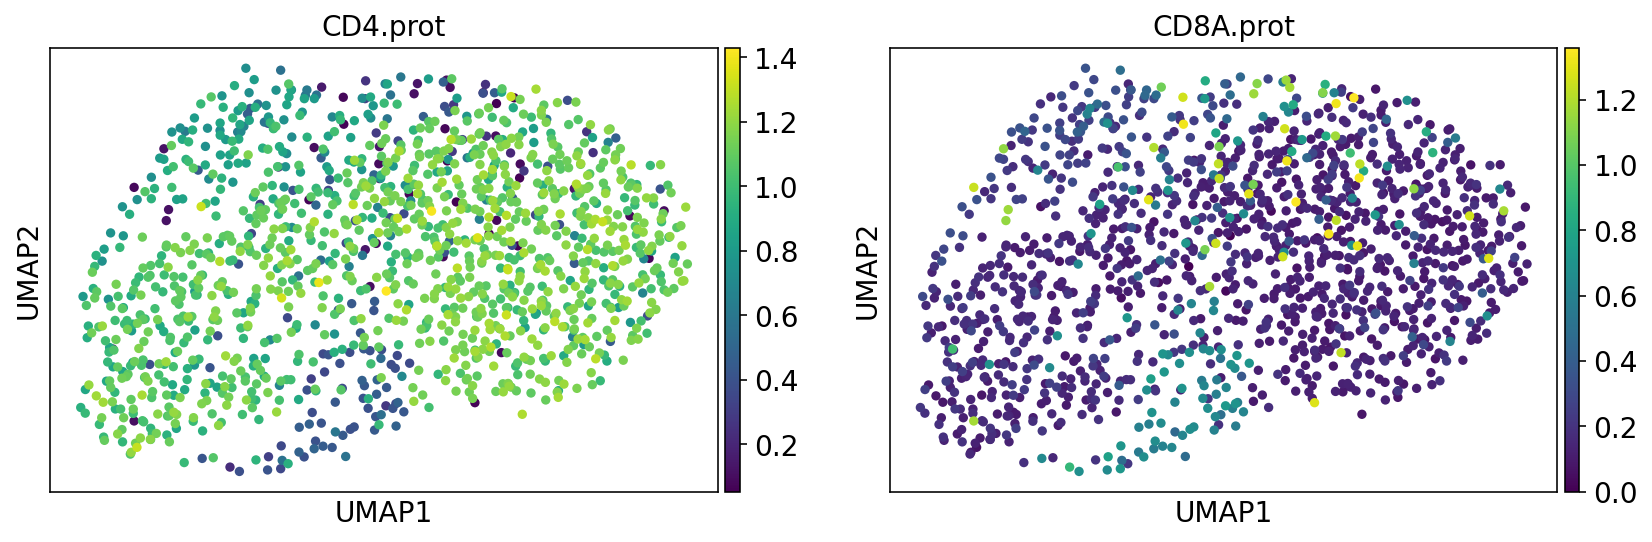

In [49]:
sc.pl.umap(adata, color=['CD4.prot','CD8A.prot'], save='_withCD4CD8a_ab.'+imageFormat)



### Finding marker genes

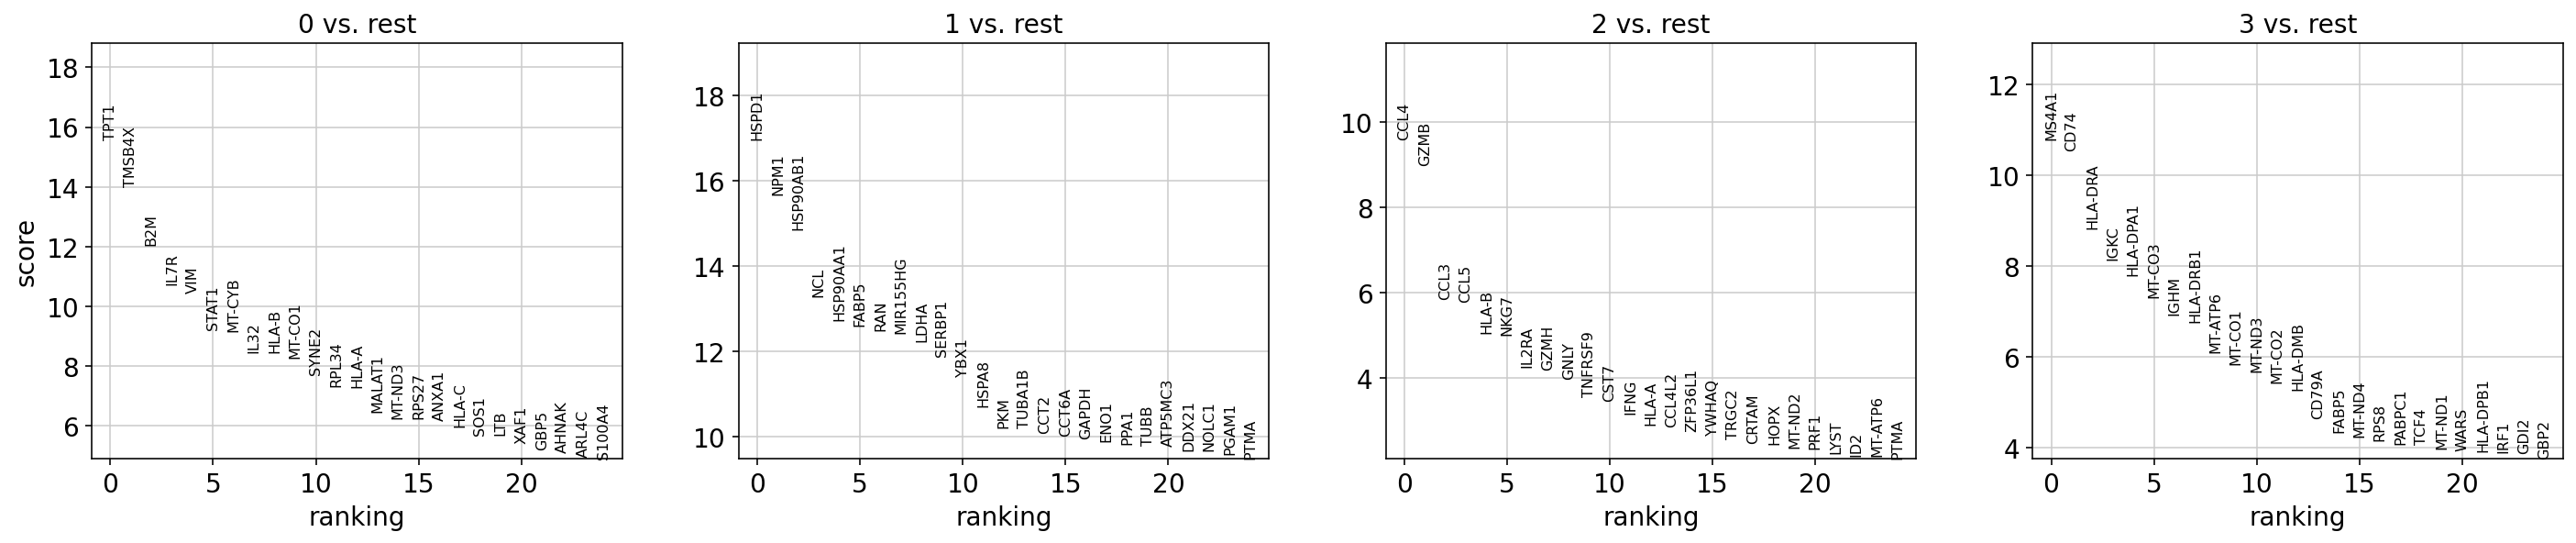

0         1        2         3
0     TPT1     HSPD1     CCL4     MS4A1
1   TMSB4X      NPM1     GZMB      CD74
2      B2M  HSP90AB1     CCL3   HLA-DRA
3     IL7R       NCL     CCL5      IGKC
4      VIM  HSP90AA1    HLA-B  HLA-DPA1
5    STAT1     FABP5     NKG7    MT-CO3
6   MT-CYB       RAN    IL2RA      IGHM
7     IL32  MIR155HG     GZMH  HLA-DRB1
8    HLA-B      LDHA     GNLY   MT-ATP6
9   MT-CO1    SERBP1  TNFRSF9    MT-CO1
10   SYNE2      YBX1     CST7    MT-ND3
11   RPL34     HSPA8     IFNG    MT-CO2
12   HLA-A       PKM    HLA-A   HLA-DMB
13  MALAT1    TUBA1B   CCL4L2     CD79A
14  MT-ND3      CCT2  ZFP36L1     FABP5
15   RPS27     CCT6A    YWHAQ    MT-ND4
16   ANXA1     GAPDH    TRGC2      RPS8
17   HLA-C      ENO1    CRTAM    PABPC1
18    SOS1      PPA1     HOPX      TCF4
19     LTB      TUBB   MT-ND2    MT-ND1

0         1      2         3
0    TPT1     HSPD1   CCL4     MS4A1
1  TMSB4X      NPM1   GZMB      CD74
2     B2M  HSP90AB1   CCL3   HLA-DRA
3    IL7R       NCL   CCL5      IGKC
4     VIM  HSP90AA1  HLA-B  HLA-DPA1

In [50]:

sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save='.'+imageFormat)
results_file = out_dir+"annData.hdf5"
adata.X = csr_matrix(adata.X)

#show the top 20 markers in a data frame
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20))
#get a tabale with the scores and goupr
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']}).head(25) #pvals
#save to a file
df.to_csv(fr"{out_dir}clusters_markers_top25.tsv", index=None, sep='\t', mode='a')

#show the top 5 markers in a data frame
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5))
#get a tabale with the scores and goupr
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)




### Give a name to the leiden clusters

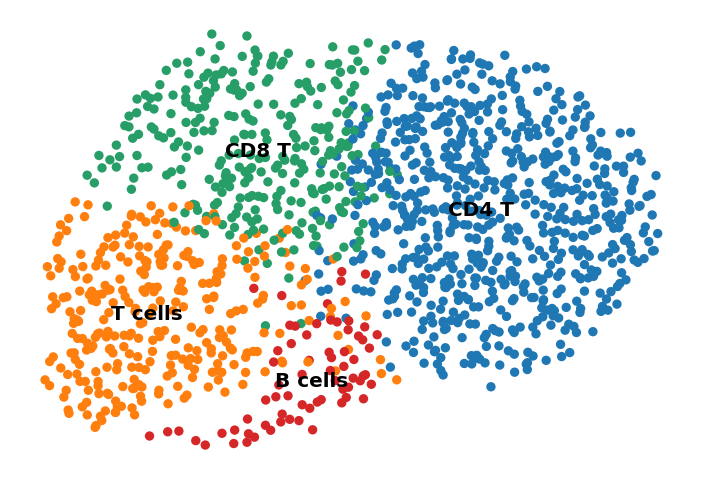

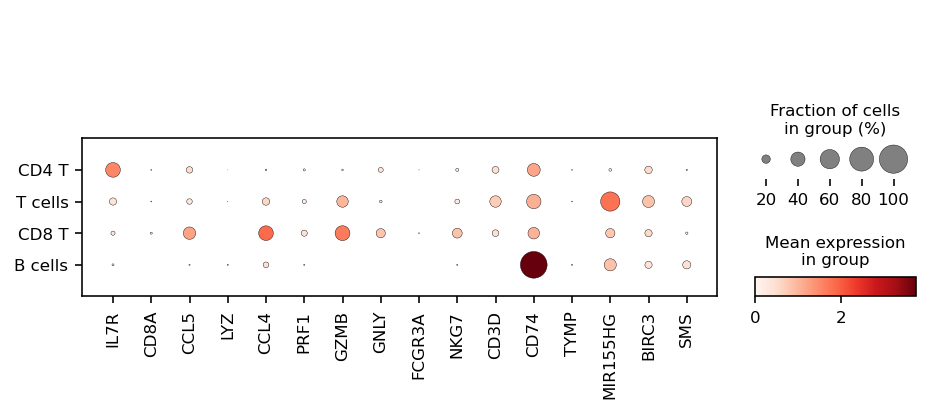

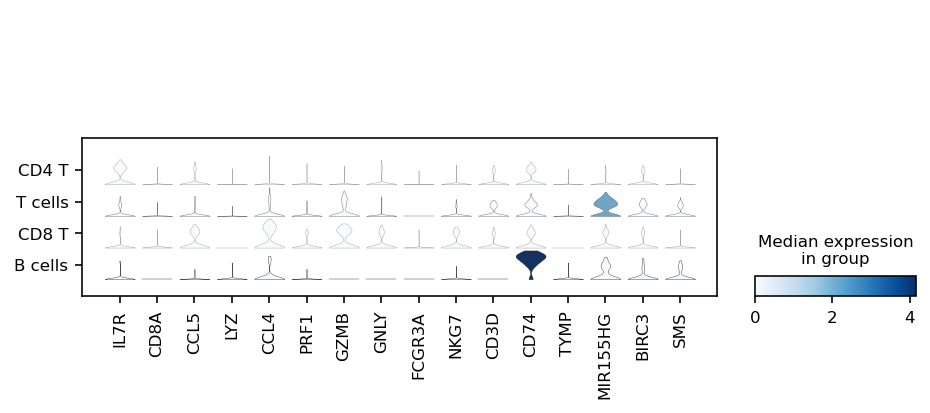

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 12
📂 Storing models in /home/localadmin/.celltypist/data/models
💾 Downloading model [1/12]: Immune_All_Low.pkl
💾 Downloading model [2/12]: Immune_All_High.pkl
💾 Downloading model [3/12]: Adult_Mouse_Gut.pkl
💾 Downloading model [4/12]: COVID19_Immune_Landscape.pkl
💾 Downloading model [5/12]: Cells_Fetal_Lung.pkl
💾 Downloading model [6/12]: Cells_Intestinal_Tract.pkl
💾 Downloading model [7/12]: Cells_Lung_Airway.pkl
💾 Downloading model [8/12]: Developing_Mouse_Brain.pkl
💾 Downloading model [9/12]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [10/12]: Human_Lung_Atlas.pkl
💾 Downloading model [11/12]: Nuclei_Lung_Airway.pkl
💾 Downloading model [12/12]: Pan_Fetal_Human.pkl
👉 Detailed model information can be found at `https://www.celltypist.org/models`


model  \
0             Immune_All_Low.pkl   
1            Immune_All_High.pkl   
2            Adult_Mouse_Gut.pkl   
3   COVID19_Immune_Landscape.pkl   
4           Cells_Fetal_Lung.pkl   
5     Cells_Intestinal_Tract.pkl   
6          Cells_Lung_Airway.pkl   
7     Developing_Mouse_Brain.pkl   
8       Healthy_COVID19_PBMC.pkl   
9           Human_Lung_Atlas.pkl   
10        Nuclei_Lung_Airway.pkl   
11           Pan_Fetal_Human.pkl   

                                          description  
0   immune sub-populations combined from 20 tissue...  
1   immune populations combined from 20 tissues of...  
2   cell types in the adult mouse gut combined fro...  
3   immune subtypes from lung and blood of COVID-1...  
4     cell types from human embryonic and fetal lungs  
5   intestinal cells from fetal, pediatric (health...  
6   cell populations from scRNA-seq of five locati...  
7   cell types from the embryonic mouse brain betw...  
8   peripheral blood mononuclear cell types from h...  
9   integrated Human Lung Cell Atlas (HLCA) combin...  
10  cell populations from snRNA-seq of five locati...  
11  stromal and immune populations from the human ...

🔬 Input data has 1369 cells and 10403 genes
🔗 Matching reference genes in the model
🧬 3393 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


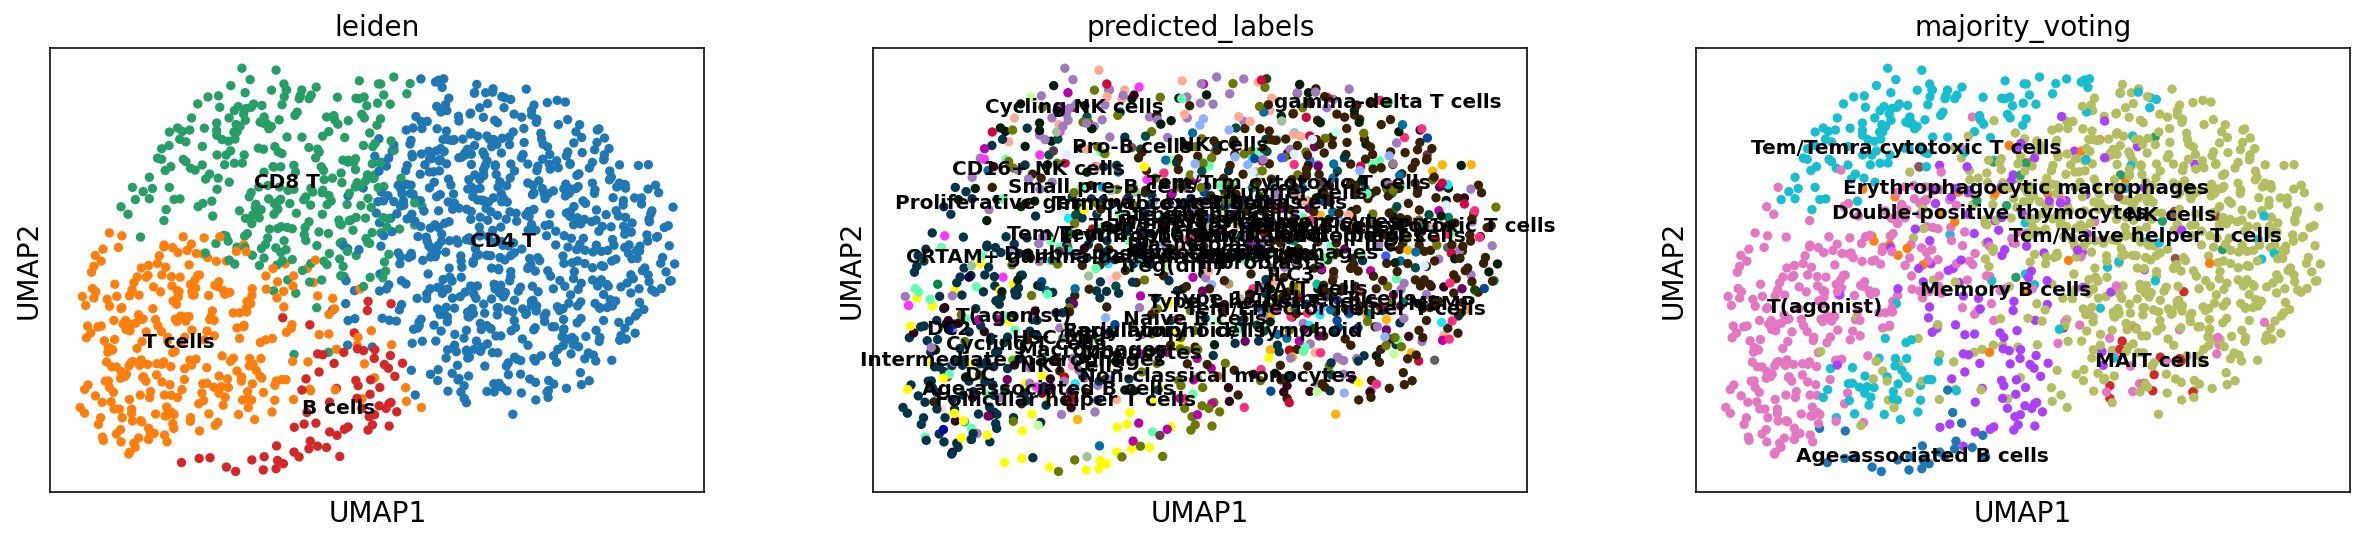

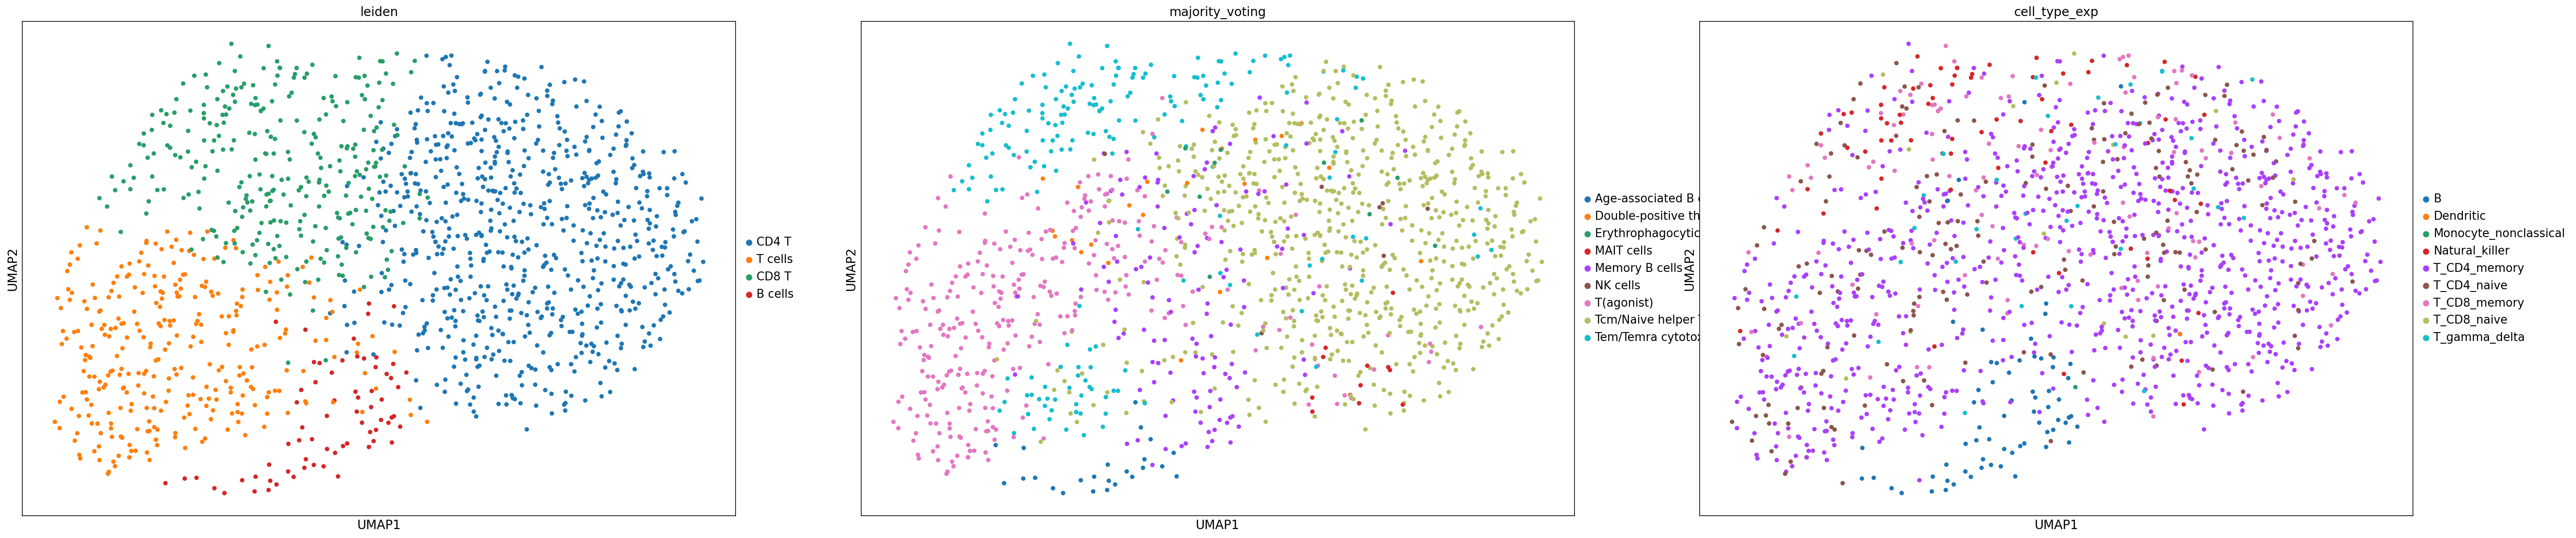

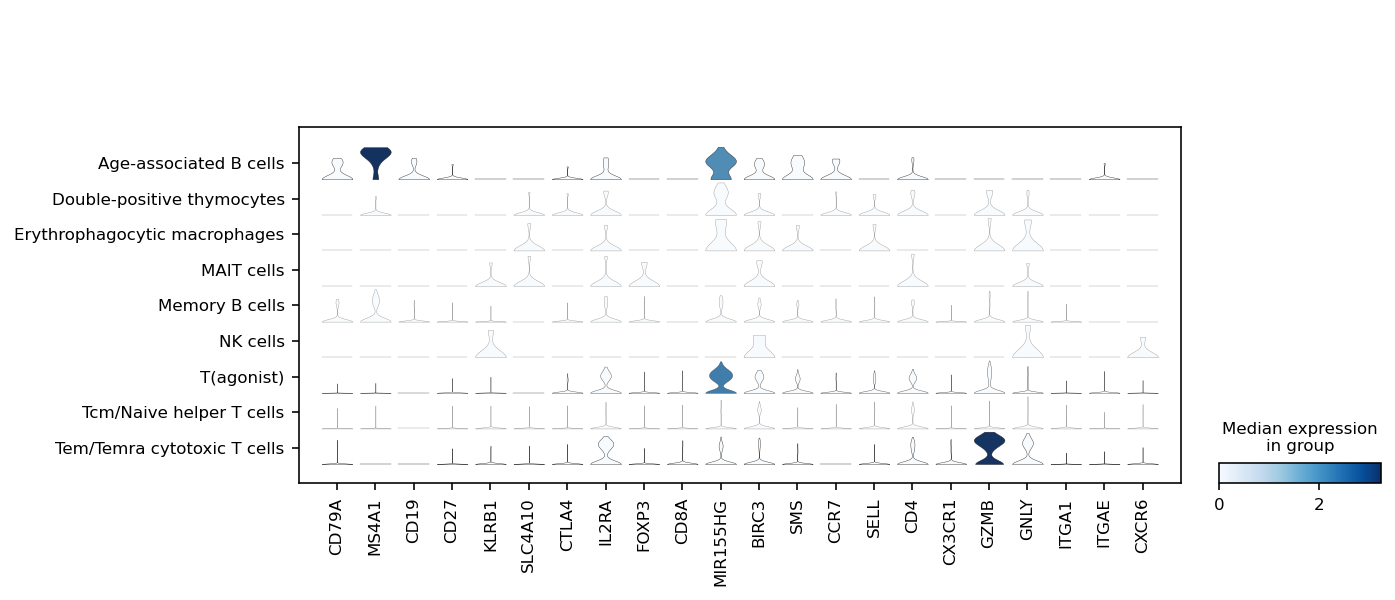

In [51]:

#Mark the cell type
new_cluster_names = [
    'CD4 T','T cells','CD8 T','B cells']

adata.obs['leiden'] = adata.obs['leiden'].cat.rename_categories(new_cluster_names)
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='_withClusterNames.png')

#Set manually the marker genes of the different clusters
marker_genes = ['IL7R', 'CD8A',  'CCL5',  'LYZ', 
                'CCL4', 'PRF1', 'GZMB', 'GNLY', 'FCGR3A', 'NKG7', 'CD3D',
                'CD74',   'TYMP','MIR155HG','BIRC3','SMS'
                ] 
#Visualize the marker genes
sc.pl.dotplot(adata, marker_genes, categories_order=['CD4 T','T cells','CD8 T','B cells'],
              groupby='leiden', save='_markers.'+imageFormat)
#as compatc violin plots
sc.pl.stacked_violin(adata, marker_genes, categories_order=[ 'CD4 T','T cells','CD8 T','B cells'],
                     groupby='leiden', rotation=90, save='_markers.'+imageFormat)



#Try to use CellTypist to annotate the data
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)
#Show all available models that can be downloaded and used.
display(models.models_description())
#Download a specific model, for example, `Immune_All_Low.pkl`.
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_Low.pkl')
model.cell_types
model.description
# Not run; predict cell identities using this loaded model.
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting = True)

predictions.predicted_labels
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata_with_prediction = predictions.to_adata()
#visualize the prediction
sc.pl.umap(adata_with_prediction, color = ['leiden', 'predicted_labels', 'majority_voting'], legend_loc = 'on data',
           save='_PREDICTIONS.'+imageFormat)
matplotlib.rcParams['figure.figsize'] = 15, 10
sc.pl.umap(adata_with_prediction, color = ['leiden',  'majority_voting', 'cell_type_exp'], size=100,
           save='_PREDICTIONS_V2.'+imageFormat,)

marker_genes = [ 'CD79A','MS4A1','CD19', #B cells
                'CD27', #memory B cells 'CR2',
                'KLRB1','SLC4A10', #MAIT
                'CTLA4','IL2RA','FOXP3', #Treg
                'CD8A', # double pos thymo CD4 CD8 'CD1',
                'MIR155HG','BIRC3','SMS', #T agonist
                'CCR7','SELL','CD4', # Tcm/naive CD4 helper T cell
                'CX3CR1','GZMB','GNLY', # CD8+ cytotoxic T lymphocyte Tem/Temra
                'ITGA1','ITGAE','CXCR6'# CD8+ cytotoxic T lymphocyte Trm
                ] 
sc.pl.stacked_violin(adata, marker_genes,
                     groupby='majority_voting', rotation=90, save='_cellTypistMarkers.'+imageFormat)



### UMAP plot using the CellTypist annotation (publication)

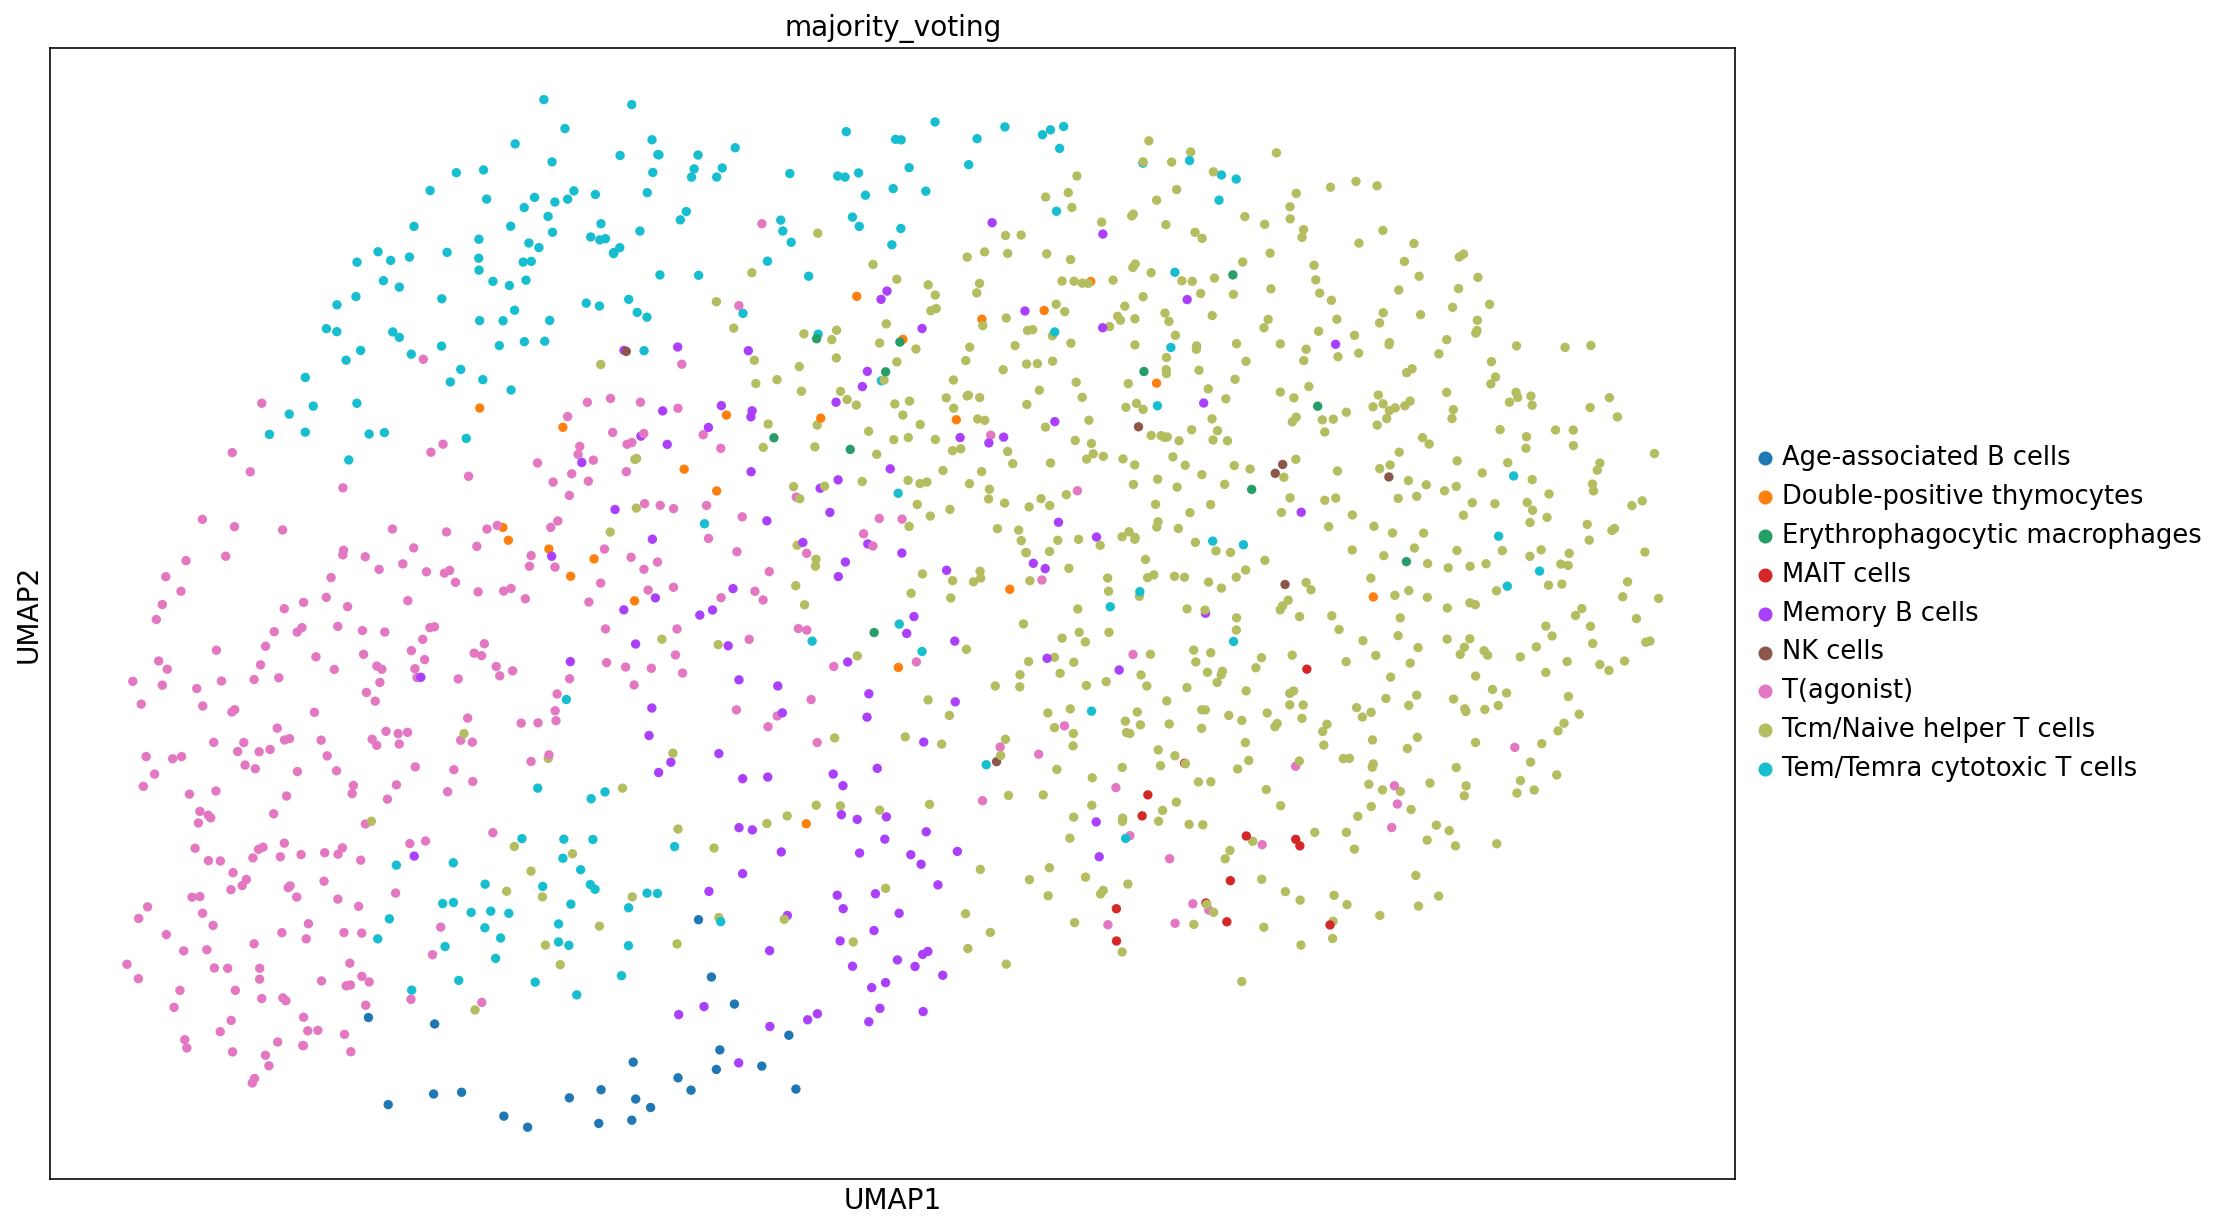

In [52]:
sc.pl.umap(adata_with_prediction, color = ['majority_voting'], 
           save='_BD_CELLTYPIST.'+imageFormat,)

##### Dotplot for the paper with cellTypist annotation

In [53]:

#we print out the number of cells by cell type
cluster_counts = adata.obs['majority_voting'].value_counts()
print(cluster_counts)

# we remove the ones <10 (Dendritic and monocyte have 1 cell)
adata=adata[adata.obs['majority_voting'].isin( cluster_counts[cluster_counts>5].index)].copy()
cluster_counts = adata.obs['majority_voting'].value_counts()
print(cluster_counts)

#we rename by adding the number of cells
selCells = list(adata[adata.obs['majority_voting']=="Tcm/Naive helper T cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Tcm/Naive helper T cells (n=657)"
selCells = list(adata[adata.obs['majority_voting']=="T(agonist)"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="T(agonist)  (n=313)"
selCells = list(adata[adata.obs['majority_voting']=="Tem/Temra cytotoxic T cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Tem/Temra cytotoxic T cells (n=197)"
selCells = list(adata[adata.obs['majority_voting']=="Memory B cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Memory B cells (n=124)"
selCells = list(adata[adata.obs['majority_voting']=="Age-associated B cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Age-associated B cells (n=24)"
selCells = list(adata[adata.obs['majority_voting']=="Double-positive thymocytes"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Double-positive thymocytes (n=23)"
selCells = list(adata[adata.obs['majority_voting']=="MAIT cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="MAIT cells (n=13)"
selCells = list(adata[adata.obs['majority_voting']=="Erythrophagocytic macrophages"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="Erythrophagocytic macrophages (n=11)"
selCells = list(adata[adata.obs['majority_voting']=="NK cells"].obs.index)
adata.obs.loc[adata.obs.index.isin(selCells),'cell_type_exp_n']="NK cells (n=7)"





Tcm/Naive helper T cells         657
T(agonist)                       313
Tem/Temra cytotoxic T cells      197
Memory B cells                   124
Age-associated B cells            24
Double-positive thymocytes        23
MAIT cells                        13
Erythrophagocytic macrophages     11
NK cells                           7
Name: majority_voting, dtype: int64
Tcm/Naive helper T cells         657
T(agonist)                       313
Tem/Temra cytotoxic T cells      197
Memory B cells                   124
Age-associated B cells            24
Double-positive thymocytes        23
MAIT cells                        13
Erythrophagocytic macrophages     11
NK cells                           7
Name: majority_voting, dtype: int64


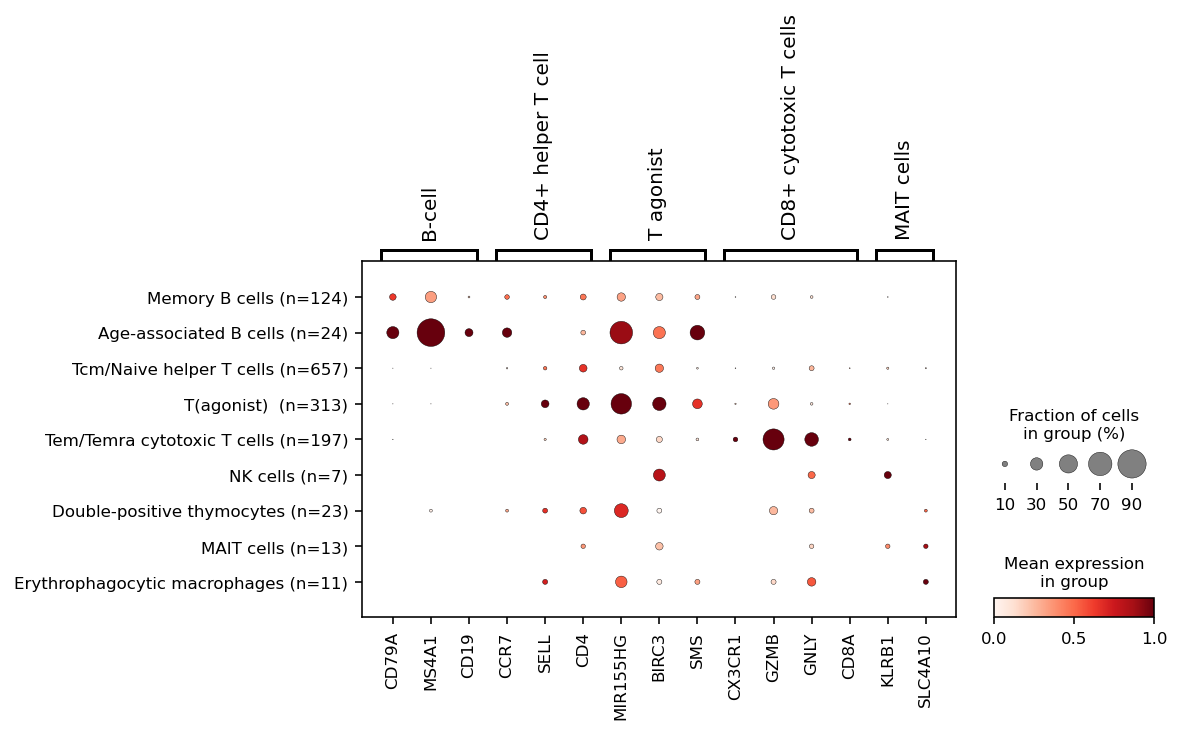

In [54]:
markers = { "B-cell": ['CD79A','MS4A1','CD19'], #B cells
            "CD4+ helper T cell":['CCR7','SELL','CD4'], # CD4+ helper T cell
            "T agonist":['MIR155HG','BIRC3','SMS']    , #T agonist
            "CD8+ cytotoxic T cells":['CX3CR1','GZMB','GNLY','CD8A'],  # Tem/Temra cytotoxic T cells
            "MAIT cells": ['KLRB1','SLC4A10']
        } 

sc.pl.dotplot( 
    adata,
    markers,
    categories_order=["Memory B cells (n=124)","Age-associated B cells (n=24)","Tcm/Naive helper T cells (n=657)","T(agonist)  (n=313)","Tem/Temra cytotoxic T cells (n=197)","NK cells (n=7)","Double-positive thymocytes (n=23)","MAIT cells (n=13)","Erythrophagocytic macrophages (n=11)"],
    groupby="cell_type_exp_n",save='BD_cellTypist_markers.'+imageFormat,
    standard_scale='var'
)

#### TCR data analysis
#### 1. QC analysis

Fraction of cells with more than one pair of TCRs: 0.00
Fraction of cells with one pair of TCRs: 0.49


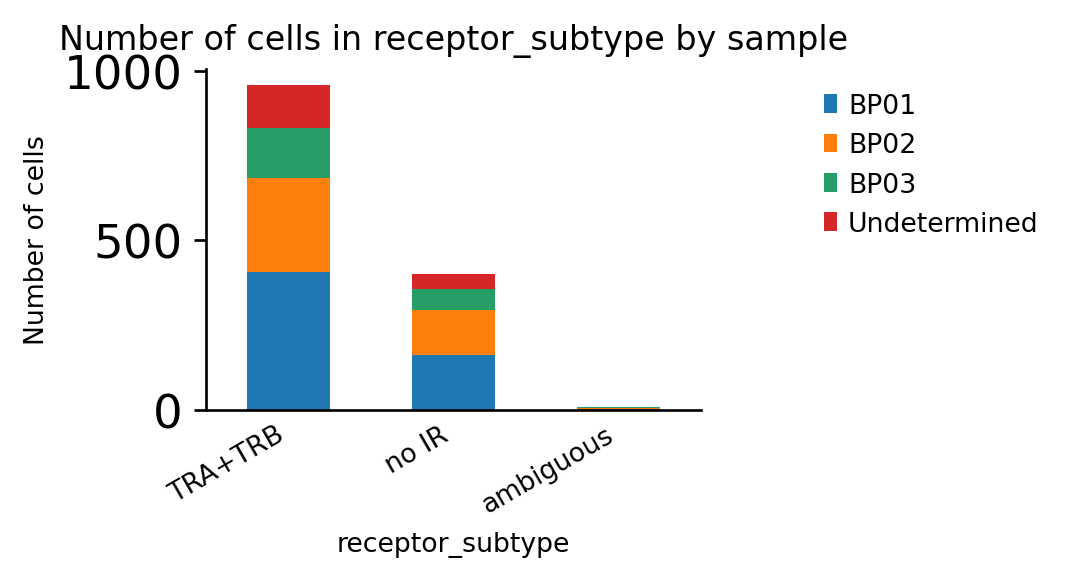

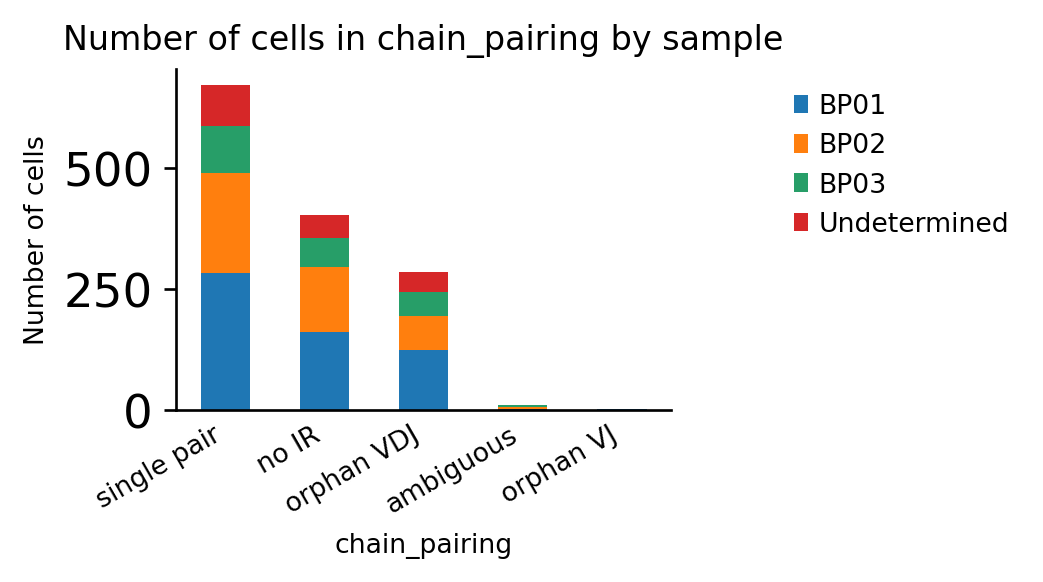

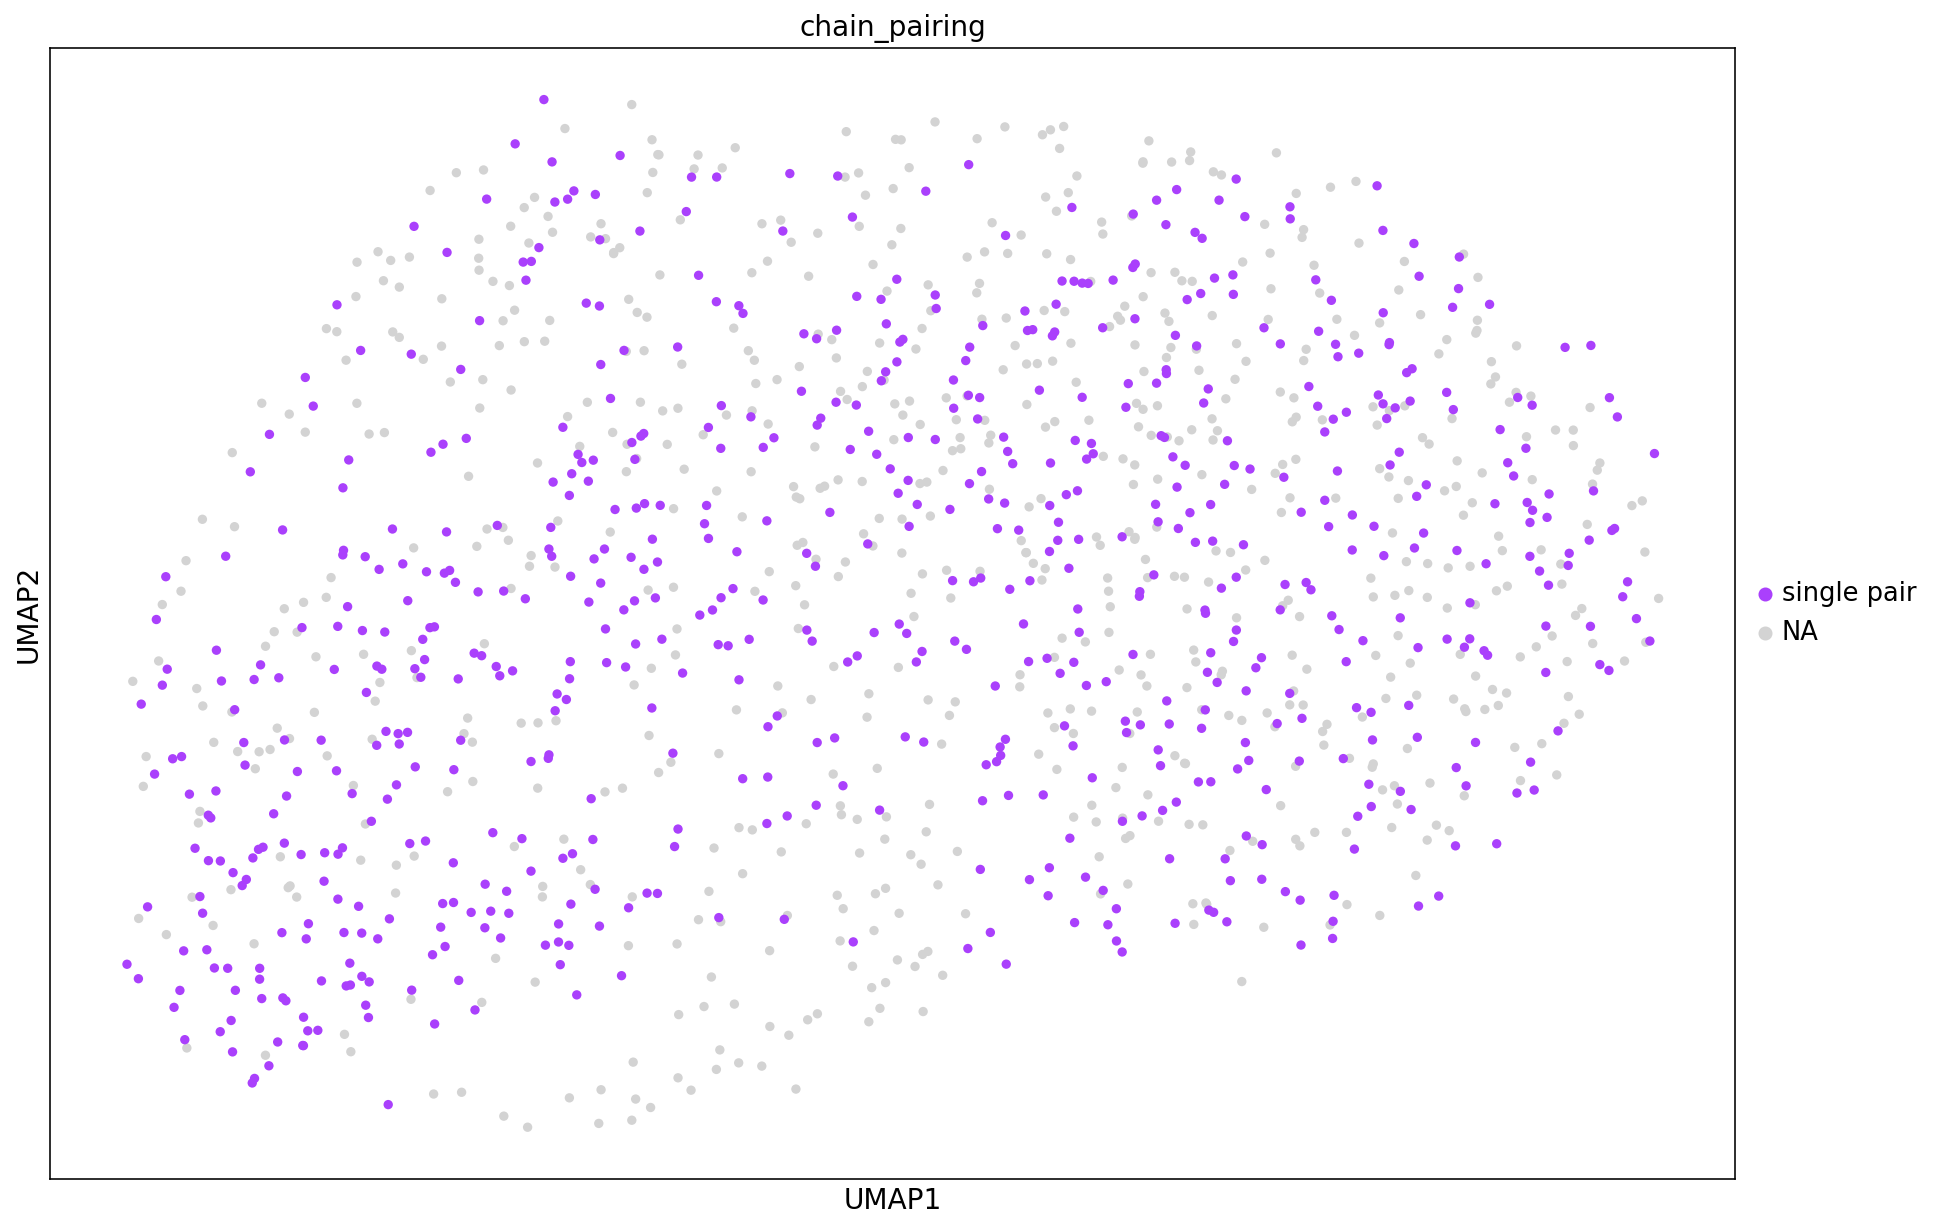

TCR FILTERING: cells with tcr = (967, 10403)
TCR FILTERING: cells with 1 single pair or orphan VDJ of tcr = (967, 10403)
BP01 TCR FILTERING: cells with 1 single pair of tcr = (408, 10403)
BP02 TCR FILTERING: cells with 1 single pair of tcr = (282, 10403)
BP03 TCR FILTERING: cells with 1 single pair of tcr = (151, 10403)
Undetermined TCR FILTERING: cells with 1 single pair of tcr = (126, 10403)


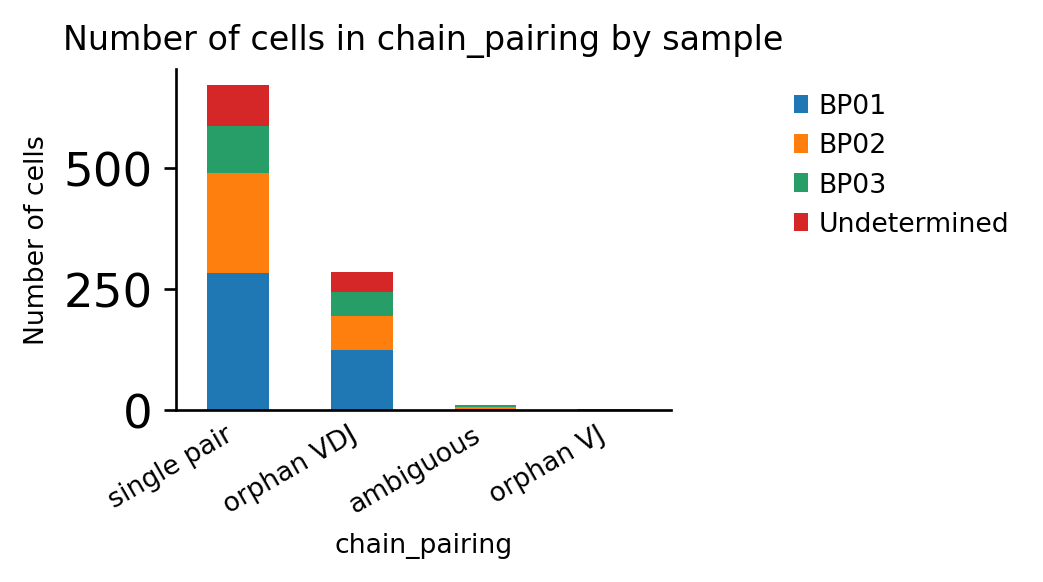

In [55]:
sc.settings.figdir=irdir

#1. Do some QC analysis
adata=adata_with_prediction
adata.obs.rename(columns={"majority_voting": "cell_type"}, inplace=True)
ir.tl.chain_qc(adata)
ax = ir.pl.group_abundance(adata, groupby="receptor_subtype", target_col="sample")
fig = ax.get_figure()
fig.savefig(irdir+'/receptorSubtype.'+imageFormat, bbox_inches='tight')
ax = ir.pl.group_abundance(adata, groupby="chain_pairing", target_col="sample")
fig = ax.get_figure()
fig.savefig(irdir+'/chainPairing_beforeFiltering.'+imageFormat, bbox_inches='tight')
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(
            adata.obs["chain_pairing"].isin(
                ["extra VJ", "extra VDJ", "two full chains"]
            )
        )
        / adata.n_obs
    )
)
print(
    "Fraction of cells with one pair of TCRs: {:.2f}".format(
        np.sum(
            adata.obs["chain_pairing"].isin(
                ["single pair"]
            )
        )
        / adata.n_obs
    )
)

#To visualize Multichain-cells on the UMAP plot
sc.pl.umap(adata, color="chain_pairing", groups="single pair", save='_multichain.'+imageFormat)

#We remove no IR cell
adata = adata[adata.obs["chain_pairing"] != "no IR", :].copy()
print("TCR FILTERING: cells with tcr =", adata.shape)
adata = adata[adata.obs["chain_pairing"] != "multichain", :].copy()
#We can use the chain_pairing information to exclude all cells that don’t have at least one full pair of receptor sequences:
#Here we decided to keep also the orphan VDJ since we have very few single pairs
print("TCR FILTERING: cells with 1 single pair or orphan VDJ of tcr =", adata.shape)

#We count how many single pair TCR cell we have for each sample/donor
print("BP01 TCR FILTERING: cells with 1 single pair of tcr =", adata[adata.obs['sample'].isin(['BP01'])].shape)
print("BP02 TCR FILTERING: cells with 1 single pair of tcr =", adata[adata.obs['sample'].isin(['BP02'])].shape)
print("BP03 TCR FILTERING: cells with 1 single pair of tcr =", adata[adata.obs['sample'].isin(['BP03'])].shape)
print("Undetermined TCR FILTERING: cells with 1 single pair of tcr =", adata[adata.obs['sample'].isin(['Undetermined'])].shape)


ax = ir.pl.group_abundance(adata, groupby="chain_pairing", target_col="sample")
fig = ax.get_figure()
fig.savefig(irdir+'/chainPairing_afterFiltering.'+imageFormat, bbox_inches='tight')

#### 2. Compute CDR3 neighborhood graph and define clonotypes

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

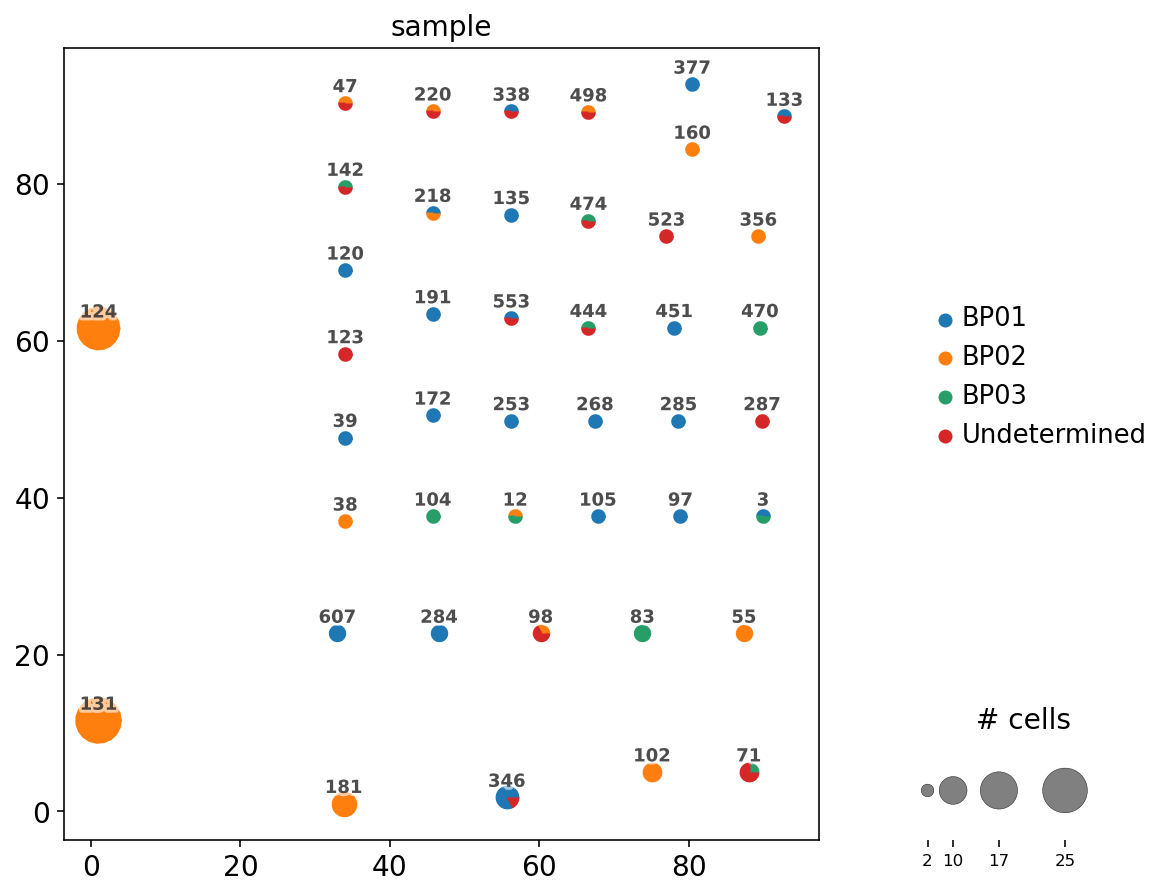

In [56]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(adata)
ir.tl.define_clonotypes(adata, receptor_arms="all", dual_ir="primary_only")
ir.tl.clonotype_network(adata, min_cells=2) #we remove singleton
ax = ir.pl.clonotype_network(
    adata, color="sample", base_size=20, label_fontsize=9, panel_size=(7, 7)
)
fig = ax.get_figure()
fig.savefig(irdir+'/clonotype_network.'+imageFormat, bbox_inches='tight')

#3.Re-compute CDR3 neighborhood graph and define clonotype clusters
ir.pp.ir_dist(
    adata,
    metric="alignment",
    sequence="aa",
    cutoff=15,
)
### Note: the clonotypes cluster functions work only if we take the single paired TCR, not with orphan VDJ


#### 3. Clonotype analysis

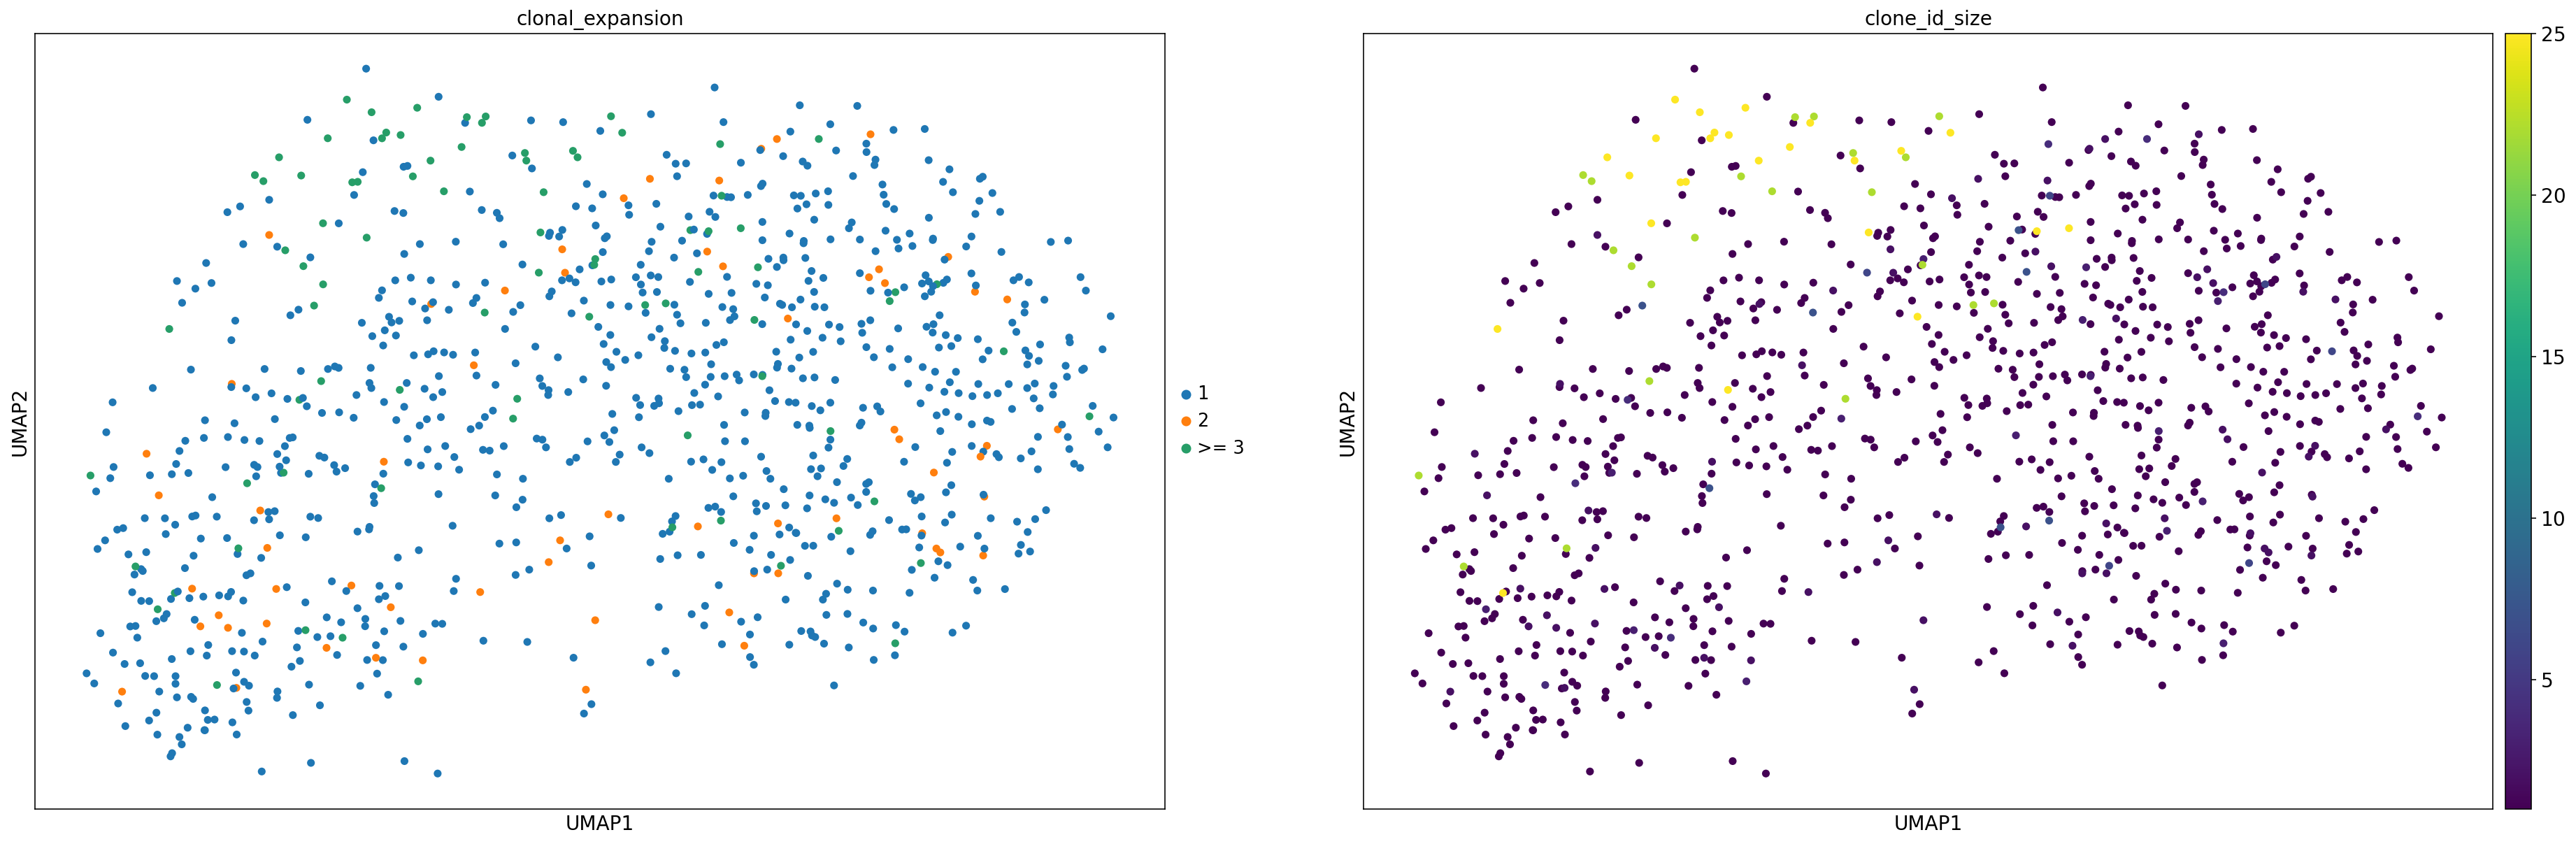

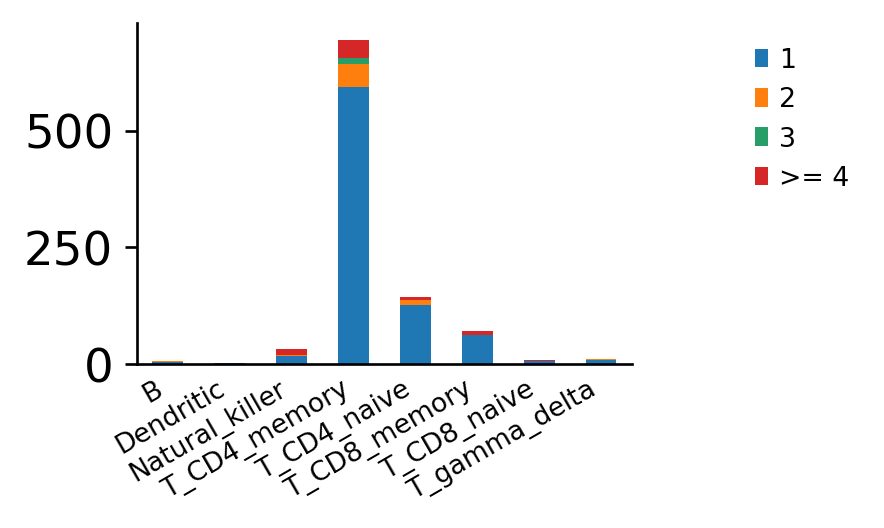

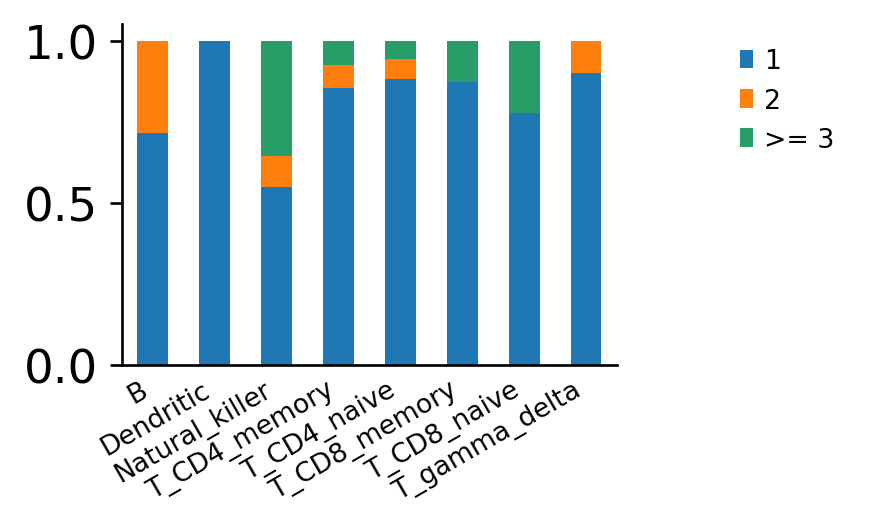

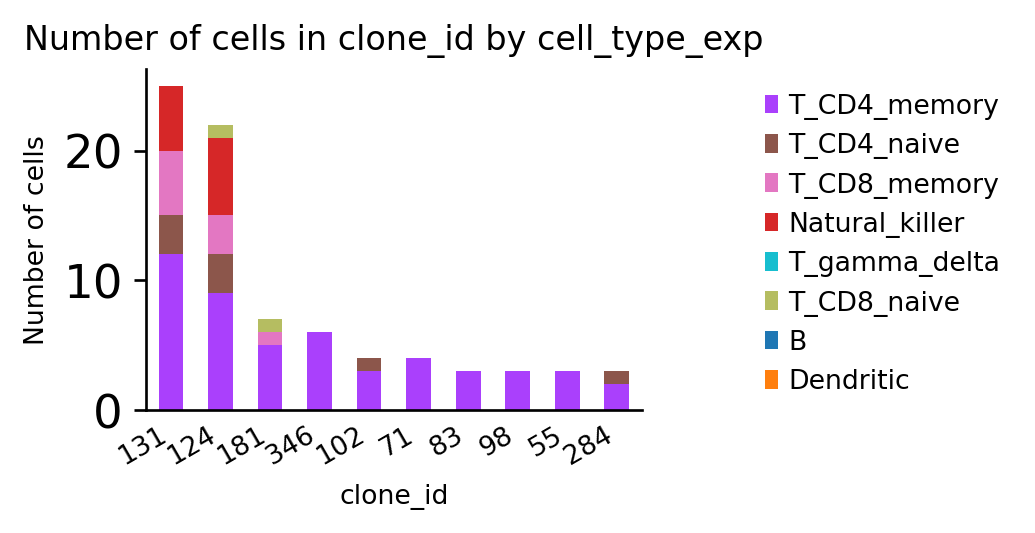

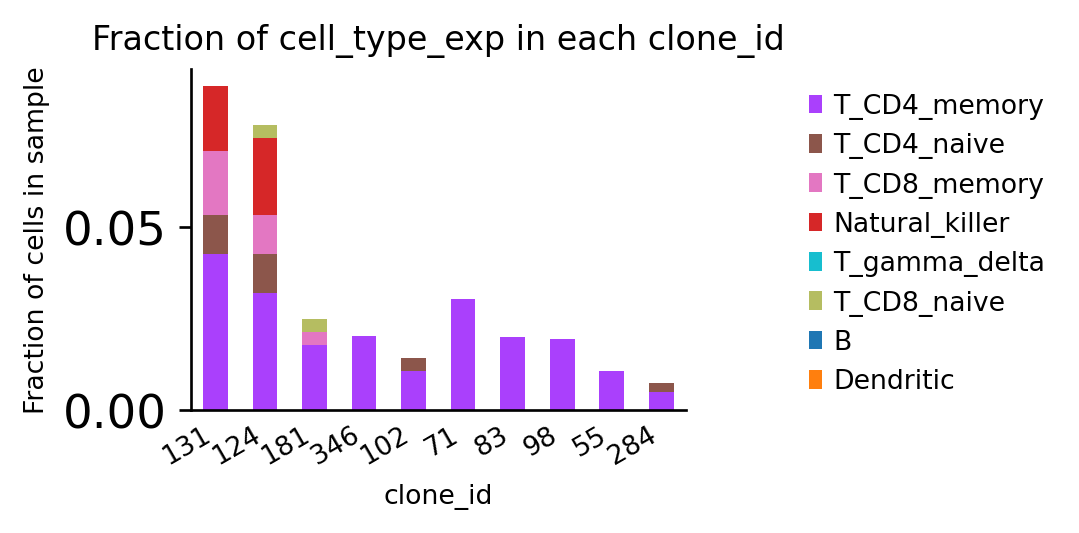

In [57]:
#5. Clonotype analysis
ir.tl.clonal_expansion(adata)
sc.pl.umap(adata, color=["clonal_expansion", "clone_id_size"], save='_clonalExpansion.'+imageFormat)

#We plot by GEX cluster
ax = ir.pl.clonal_expansion(adata, groupby="cell_type_exp", clip_at=4, normalize=False)
fig = ax.get_figure()
fig.savefig(irdir+'/clonalExpansion_byGEX_cluster.'+imageFormat, bbox_inches='tight')
#if we normalize
ax = ir.pl.clonal_expansion(adata, "cell_type_exp")
fig = ax.get_figure()
fig.savefig(irdir+'/clonalExpansion_byGEX_cluster_normalized.'+imageFormat, bbox_inches='tight')

#6. Clonotype abundance
#Show the top 10 clonotypes
ax = ir.pl.group_abundance(adata, groupby="clone_id", target_col="cell_type_exp", max_cols=10)
fig = ax.get_figure()
fig.savefig(irdir+'/top10_clonotypes.'+imageFormat, bbox_inches='tight')
#normalized with sample size
ax = ir.pl.group_abundance(
    adata, groupby="clone_id", target_col="cell_type_exp", max_cols=10, normalize="sample"
)
fig = ax.get_figure()
fig.savefig(irdir+'/top10_clonotypes_normalized.'+imageFormat, bbox_inches='tight')

#### 4. Analyzing clonotype

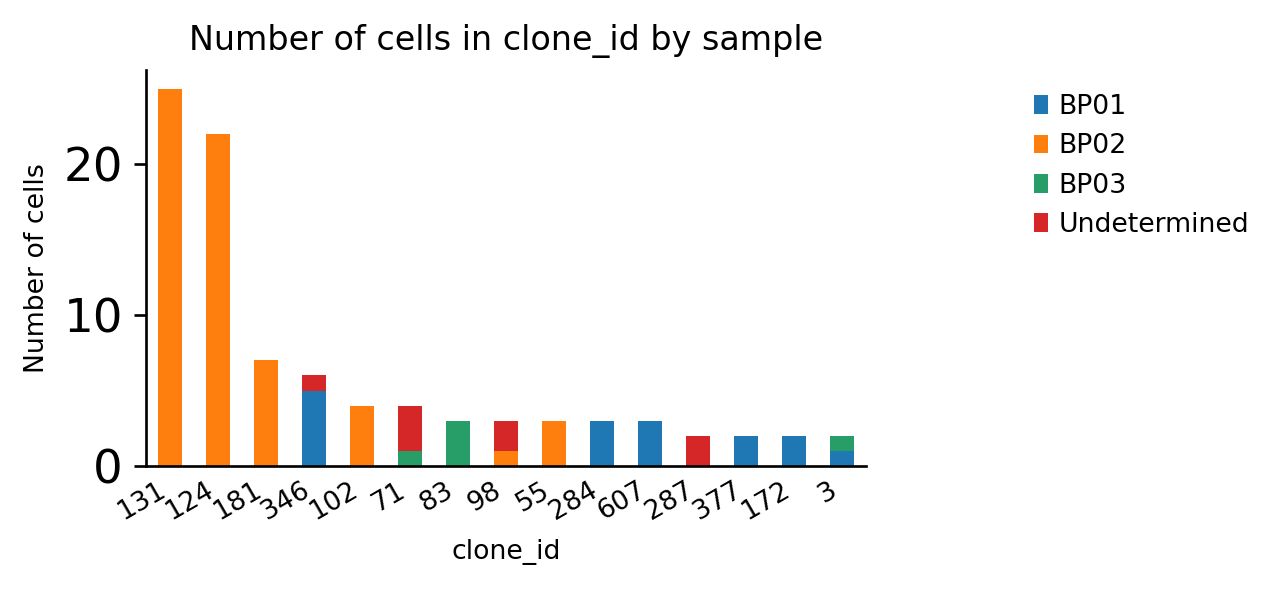

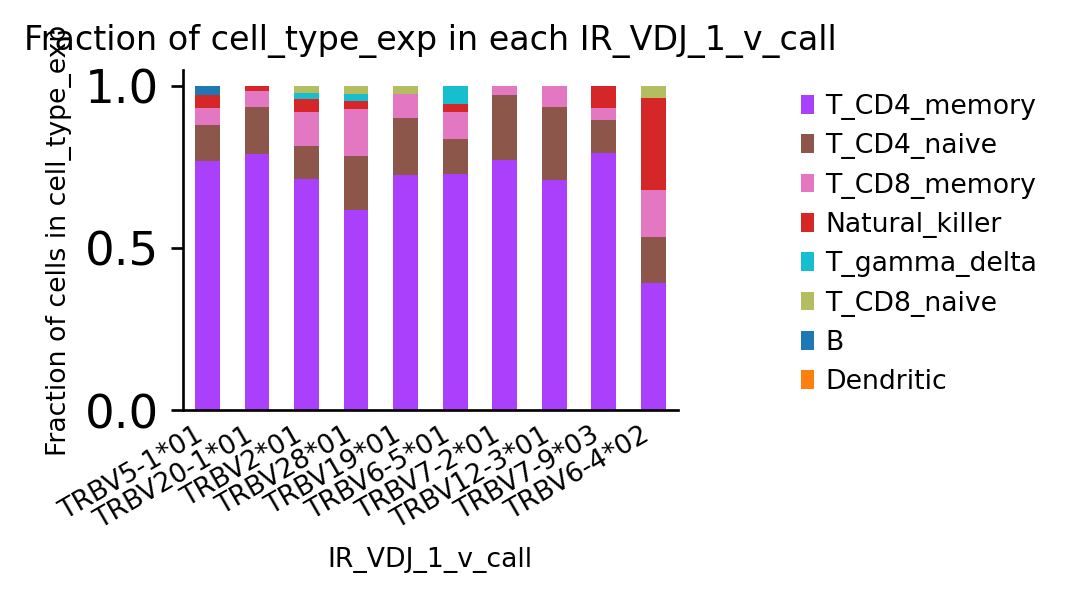

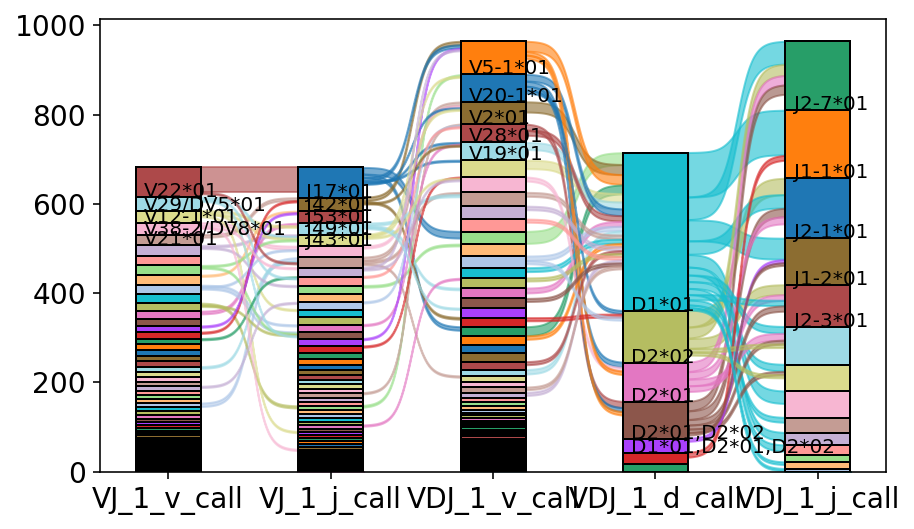

In [58]:
ax = ir.pl.group_abundance(
    adata, groupby="clone_id", target_col="sample", max_cols=15, figsize=(5, 3)
)
fig = ax.get_figure()
fig.savefig(irdir+'/top10_clonotypes_normalized.'+imageFormat, bbox_inches='tight')

#7. Gene usage
ax = ir.pl.group_abundance(
    adata, groupby="IR_VDJ_1_v_call", target_col="cell_type_exp", normalize=True, max_cols=10
)
fig = ax.get_figure()
fig.savefig(irdir+'/geneUsage_by_GEX_cluster.'+imageFormat, bbox_inches='tight')

#VDJ combinations
ax = ir.pl.vdj_usage(adata, full_combination=False, max_segments=None, max_ribbons=30)
fig = ax.get_figure()
fig.savefig(irdir+'/VDJ_combination.'+imageFormat, bbox_inches='tight')




#### 5. Integrating GEX data

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

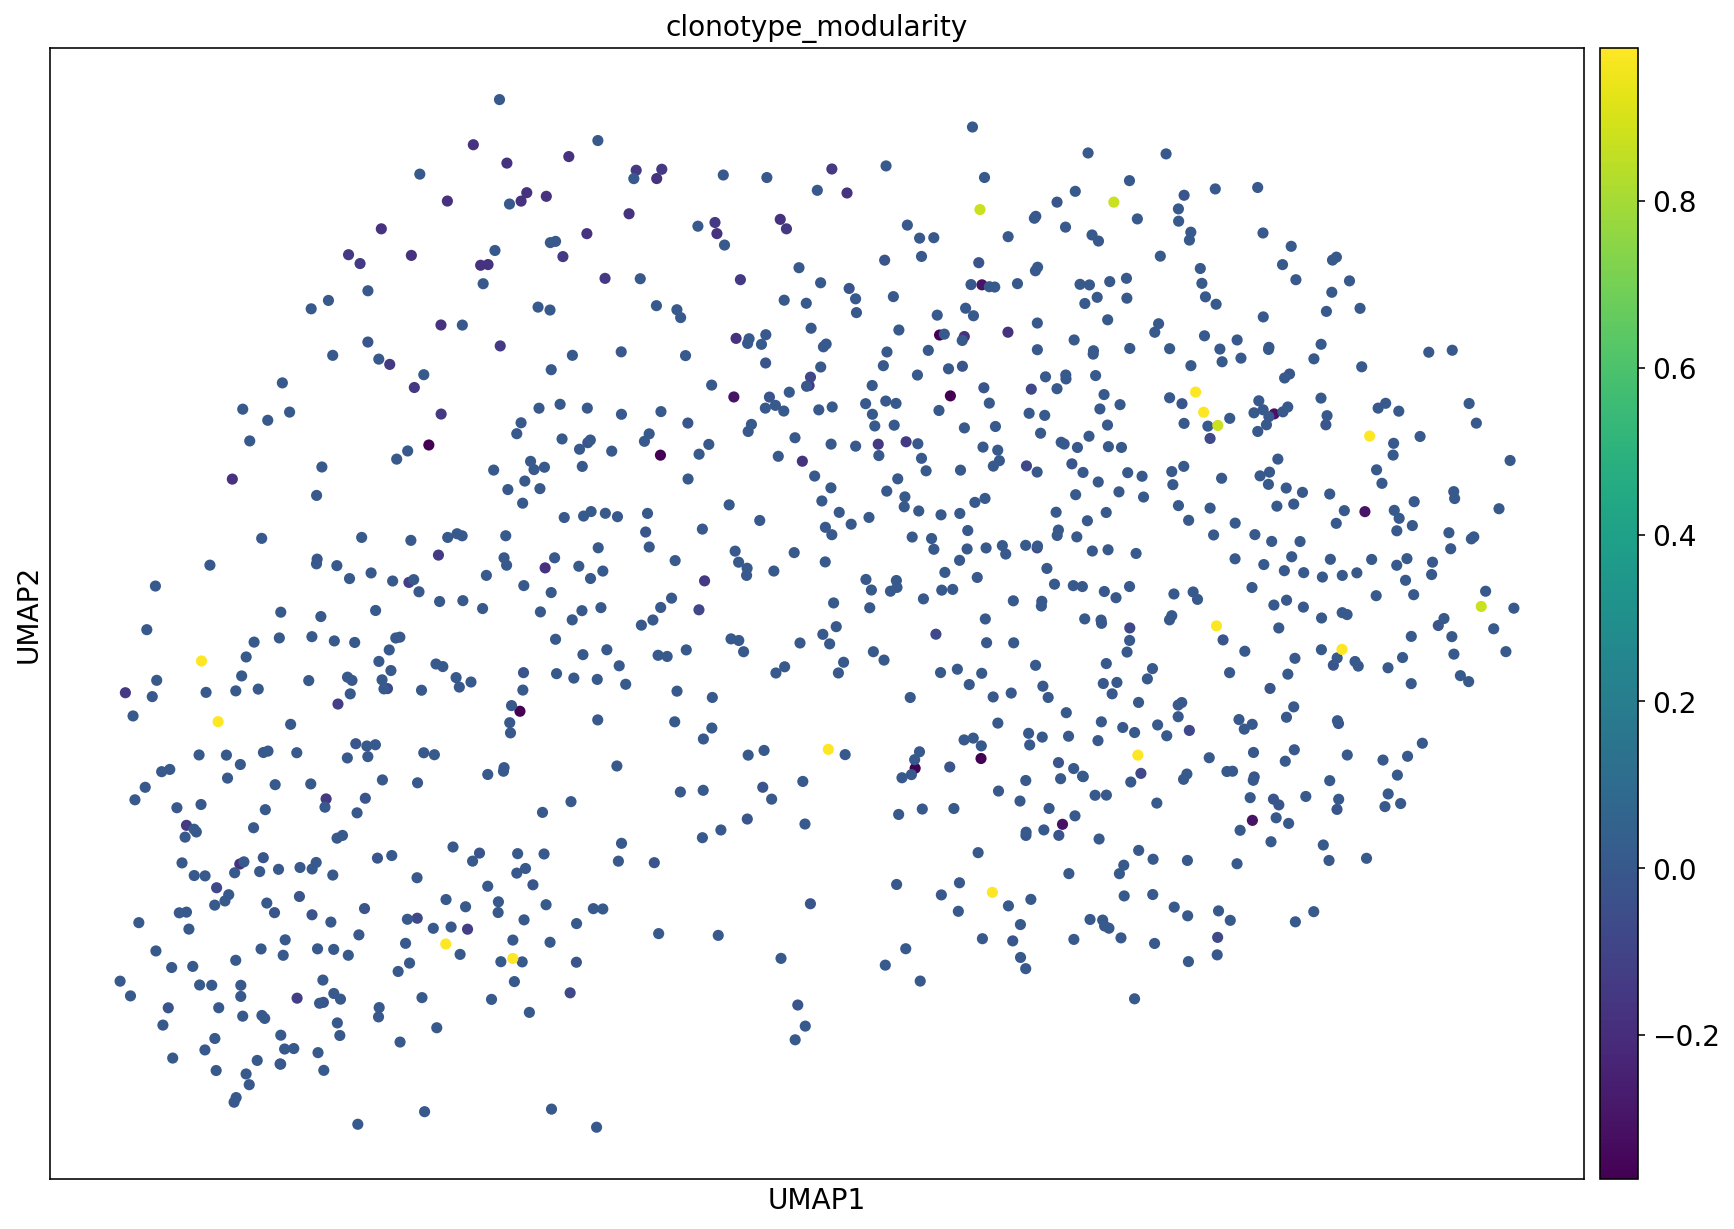

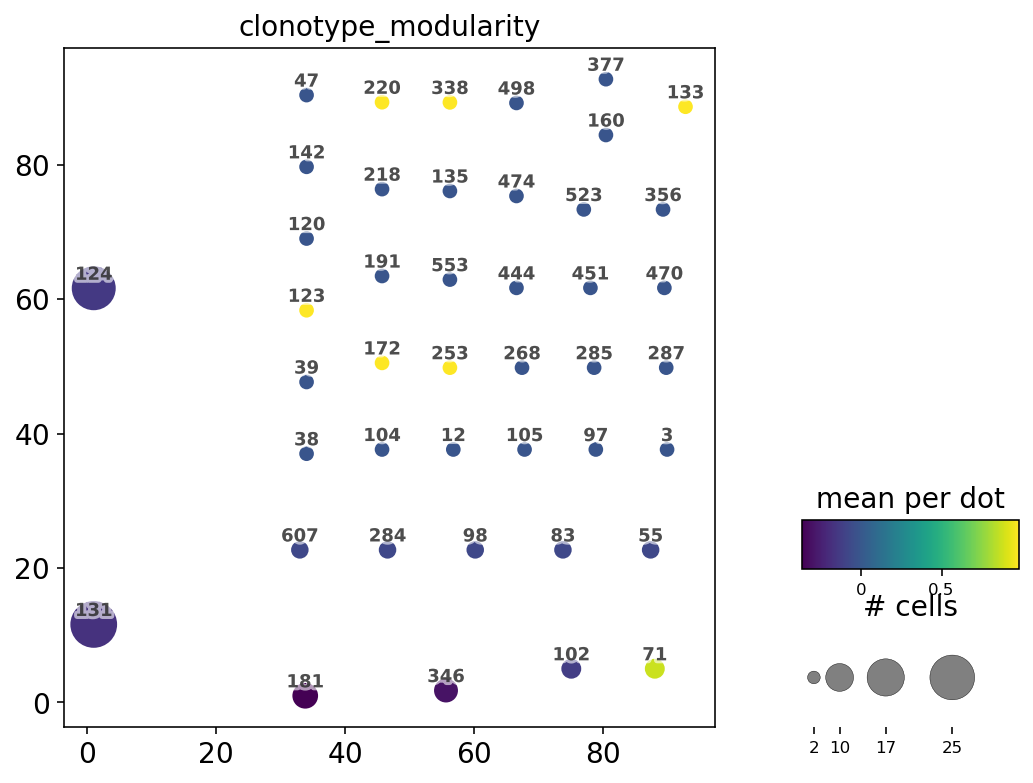

In [59]:
#print(adata.obs)
#Clonotype modularity
#To identify clonotypes that have cells with similar transcriptome
ir.tl.clonotype_modularity(adata, target_col="clone_id") # target_col="cc_aa_alignment"
sc.pl.umap(adata, color="clonotype_modularity", save='_clonotypeModularity.'+imageFormat)
ax = ir.pl.clonotype_network(
    adata,
    color="clonotype_modularity",
    label_fontsize=9,
    panel_size=(6, 6),
    base_size=20,
)
fig = ax.get_figure()
fig.savefig(irdir+'/clonotypeModularity_on_clonotype_network.'+imageFormat, bbox_inches='tight')

#Finally we write the AnnData object into AIRR format to use in other tools (i.e. : Immunarch)
ir.io.write_airr(adata, out_dir+'airrfile_data.tsv')
#We willclean this file with a Java class



#### Convert to html

In [60]:
os.system('jupyter nbconvert --to html BD_analyzeTcellFromPBMC_PUB.ipynb')

[NbConvertApp] Converting notebook BD_analyzeTcellFromPBMC_PUB.ipynb to html
[NbConvertApp] Writing 9549099 bytes to BD_analyzeTcellFromPBMC_PUB.html


0